<img align="left" width="220px" height="220px" src="https://astra.dk/sites/default/files/DTU%20logo.png" alt="logo"/>
<div>
    <h1 style="text-align: right"> Social Data Analysis and Visualization</h1>
    <h2 style="text-align: right"> Final project</h2>
</div>

# <span style="color:#990000"> Final project - Social data analysis and vizualisations

### <span style="color:#008000"> Libraries

In [1]:
# usual libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', palette='muted', color_codes=True)
import json
import matplotlib.dates as dates
import datetime
from math import log

# import from bokeh library
from bokeh.models import ColorBar, LogColorMapper, LogTicker, LinearColorMapper
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show, curdoc
from bokeh.layouts import layout
from bokeh.models import (Button, CategoricalColorMapper, ColumnDataSource,
                          HoverTool, Label, SingleIntervalTicker, Slider, RadioButtonGroup, PreText, Legend)
from bokeh.plotting import figure
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
from bokeh.layouts import row, widgetbox, layout
from bokeh.models.renderers import GlyphRenderer
from bokeh.transform import linear_cmap

# import from sklearn library
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

# Function to convert the date in pandas format datetime64 to format datetime
def convert_datetime64_to_datetime( usert: np.datetime64 )->datetime.datetime:
    t = np.datetime64( usert, 'us').astype(datetime.datetime)
    return(t)

# Filters unwanted warnings
import warnings
warnings.filterwarnings('ignore')

# <span style="color:#008000">  If you want to run and try this notebook
    
**You need to put your notebook url in the following variable.**
**It must have the following shape:** "http://localhost:XXXX"

In [2]:
# Change the value of this variable
notebook_url = "http://localhost:8888"

# <span style="color:#008000"> Table of content:
* [1. Motivation](#first-part)
* [2. Basic stats](#second-part)
* [3. Data Analysis](#third-part)
* [4. Genre](#fourth-part)
* [5. Visualizations](#fifth-part)
* [6. Discussion](#sixth-part)
* [7. Contributions](#seventh-part)

# <span style="color:#990000"> I - Motivation <a class="anchor" id="first-part">

### **Objective**

Since the beginning of the lockdown in France, hardly a day goes by without the media spreading anything and everything about Covid-19. Thus it has become tough to distinguish between true and false information. 
At the same time, the evolution of the outbreak has been more and more compared on a regional scale (the French departments) in spite of this notion of department tended to vanish in the last years.
By visualizing the Covid-19 data on the French departments scale, this study aims to assess correctly the situation and to the state whether this regional grid is useful and legitimate.

Moreover, many business activities were disrupted due to the lockdown. Thus, this study will also assess the impacts of the outbreak on road and air traffic, air quality and energy consumption. The evolution of these various indicators will be visualized before and during the period of lockdown.

### **What are the datasets?**

Many datasets were used to achieve the goal:
* The [hospital dataset](https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/## ) 
with Covid hospital data by department, provided by the French government.

* The [energy dataset](https://www.data.gouv.fr/en/datasets/donnees-eco2mix-regionales-temps-reel-1/) with energy consumption data by region, also provided by french government.

* This [flights database](https://opensky-network.org/?fbclid=IwAR0kv1M_c0D27yvT__BfF7T0CCOoqi8V2cxT6hoj3gr-JvIHHayCdnbVOLA) in which all flights are listed in the main airports worldwide

* [Air quality data](https://aqicn.org/data-platform/covid19/?fbclid=IwAR1nn_Tk9fLpg7uYIZ9tevK9wbubCfr-B-PH5JnXEjX9G_1SJWroD96tpUA) in the biggest cities worldwide, gathered by a little group of data scientists.

* Regarding locations data, a [GeoJSON file](https://france-geojson.gregoiredavid.fr/) of French departments was needed. For some data (air traffic and air pollution), a [dataset of the cities of France](https://www.data.gouv.fr/fr/datasets/regions-departements-villes-et-villages-de-france-et-doutre-mer/) including their geographical coordinates was also needed. Finally, as the energy consumption is calculated by region (a region is an entity that includes several departments in France), a dataset linking regions and departments was required.

Regarding road traffic, a dataset with data for the whole country does not exist. Only a few road traffic data within some departments are available. It seems that the French government does not centralize data collected by each department. Only private operators (Michelin, etc.) have this data set, but they did not wish to share it.

### **Goal for the end user's experience**
The objective is to provide the user with an interactive dashboard enabling him to browse the various data available and to visualize the Covid-19 impacts both at a regional scale (map) and at a country scale (line plots)

# <span style="color:#990000"> II - Basic stats <a class="anchor" id="second-part">

### **Choices in data cleaning and preprocessing**
* There is a lot of specific data cleaning and preprocessing for each dataset. Everything is presented below this part (good luck, it's long).
* Regarding preprocessing, choice was made to prefill dictionaries with all the data formatted and calculated upstream rather than proceeding with modifications/calculations on databases at the request of the user. We wanted to make interactive graphs, and if this method requires a longer loading time at the start, it then makes it possible to navigate faster through the visualization.

### <span style="color:#990000"> **There are lot of datasets and the preprocessing work is very long. Everything was put here in order to fluidify the navigation in the notebook. You might want to skip the next section and go straight to the discussion on basic statistics. To do so, click [here](#datasets_stats).**

## <span style="color:#008000">II.1 Location Data (Used to render France Map)

#### <span style="color:#008000">a - [GeoJSON file](https://france-geojson.gregoiredavid.fr/) of departments in France

In [3]:
""" Load GeoJson file and store data in variables"""

# Load geojson file with department data
with open('datasets/departements.geojson.txt') as f:
    geodata = json.load(f)
    

# Initialization
department = {}          # To store geodata for each department
lat_by_department = []   # List of lists of lat for each department
lon_by_department = []   # List of list of lon for each department
name_department = []     # List of names of departments


# Loop on all department in the geojson loaded file
for feature in geodata['features']:
    
    # Retrieves the number of the department and add it to list
    number = feature['properties']['code'] 
    
    
    # Retrieves the name of the department and add it to list
    name = feature['properties']['nom']
    name_department.append(name)
    
    # Retrieves the coordinates of the shape of the department
    coordinates = feature['geometry']['coordinates']  
    
    lat = []
    lon = []
    
    # For some region, the coordinates are entered in a really weird way
    # You have to play with lists nested in lists
    for j in range(len(coordinates)):
        lat_intermediate = []
        lon_intermediate = []
        for i in range(len(coordinates[j])):
            if len(coordinates[j][i]) == 2:
                lat_intermediate.append(coordinates[j][i][1])
                lon_intermediate.append(coordinates[j][i][0])
            else:
                for k in range(len(coordinates[j][i])):
                    lat_intermediate.append(coordinates[j][i][k][1])
                    lon_intermediate.append(coordinates[j][i][k][0])
        if len(lat_intermediate) > len(lat):
            lat = lat_intermediate
            lon = lon_intermediate
           

    # Add to list of lat and lon for each department
    lat_by_department.append(lat)
    lon_by_department.append(lon)    
    
    # Add new entry to dictionary
    # The number of department is the key
    # The value of the dictionary is a dictionary containign both the name of the department, and list with latitudes and longitudes
    department[number] = {'name':name, 'lat': lat, 'lon': lon}


#### <span style="color:#008000">b- Dataset to match departments and regions in France

In [4]:
# load dataset
df_match_region_department = pd.read_csv("datasets/region_to_department.csv", sep=";")

# Drop NA
df_match_region_department = df_match_region_department.dropna()

""" ------------ Create matching dictionary ------------"""
# Initialize
region_to_department = {}

# Fill dictionnary
for id in list(df_match_region_department["NUMÉRO"].unique()):
    region = list(df_match_region_department.loc[df_match_region_department['NUMÉRO'] == id, 'REGION'])[0]
    
    # Adapt to dataframe way of writting Grand-Est
    if region == "Grand Est":
        region = "Grand-Est"
        
    region_to_department[id] = region
    

# Check if all id from geojson file are in the matching dictionary
for id in department:
    if id not in region_to_department:
        print("This id has no match:", id)

#### <span style="color:#008000">c- [Dataset of cities](https://www.data.gouv.fr/fr/datasets/regions-departements-villes-et-villages-de-france-et-doutre-mer/) in France

In [5]:
# load dataset
df_cities = pd.read_csv("datasets/villes_france.csv", sep=",", names=[i for i in range(26)])

# Keep only columns we are interested in
df_cities = df_cities[[4, 18, 19]]

# Rename columns
df_cities.columns = ['name', 'lon', 'lat']

df_cities.head()

,name,lon,lat
1,Ozan,4.91667,46.3833
2,Cormoranche-sur-Saône,4.83333,46.2333
3,Plagne,5.73333,46.1833
4,Tossiat,5.31667,46.1333
5,Pouillat,5.43333,46.3333


## <span style="color:#008000"> II.2 Hospital [data](https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/## )


### <span style="color:#008000">a- General preparation

In [6]:
df_hospital = pd.read_csv("datasets\donnees-hospitalieres-covid19-2020.csv", sep=";")

# Let's change columns name to make them more meaningful
df_hospital.rename(columns={"dep":"department",
                           "sexe":"gender",   
                           "jour":"date",
                           "hosp":"hospitalized",
                           "rea":"intensive_care",
                           "rad":"returned_home",
                           "dc":"death"}, inplace=True)

# We only need gender 0 which refers to men+women
df_hospital = df_hospital[df_hospital.gender==0]

# Convert string date to datetime
df_hospital["date"] = pd.to_datetime(df_hospital["date"], format='%Y-%m-%d')
df_hospital=df_hospital[["date","department","gender","hospitalized","intensive_care","death","returned_home"]]

# We are not interested in returned_home and gender
df_hospital_groupby = df_hospital.groupby(['date','department']).sum()
del df_hospital_groupby["gender"] 
del df_hospital_groupby["returned_home"]

print(df_hospital.shape)
df_hospital_groupby.head()


(5758, 7)


hospitalized  intensive_care  death
date       department                                     
2020-03-18 01                     2               0      0
           02                    41              10     11
           03                     4               0      0
           04                     3               1      0
           05                     8               1      0

### <span style="color:#008000">b- Preparation for line plots

In [7]:
#evolution over time for the whole country
df_hospital_France = df_hospital_groupby.sum(level=0)

# Rename columns
df_hospital_France .rename(columns={"hospitalized":"Hospitalized",
                           "intensive_care":"Intensive_care",   
                           "death":"Cumulated_deceased"}, 
                   inplace=True)
#df_evolution.reset_index(inplace=True)
df_hospital_France.head()

,Hospitalized,Intensive_care,Cumulated_deceased
date,,,
2020-03-18,2972,771,218
2020-03-19,4073,1002,327
2020-03-20,5226,1297,450
2020-03-21,5900,1453,525
2020-03-22,6954,1674,632


In [8]:
""" Initialization"""

# Get list of dates in the dataframe
hospital_dates_str = df_hospital_France.index.strftime('%m/%d/%Y')

# Add a new columns to order rows with integers
df_hospital_France['integer']=[i for i in range(len(df_hospital_France))]
df_hospital_France.head(2)

,Hospitalized,Intensive_care,Cumulated_deceased,integer
date,,,,
2020-03-18,2972,771,218,0
2020-03-19,4073,1002,327,1


In [9]:
df_hospital_France.dtypes

Hospitalized          int64
Intensive_care        int64
Cumulated_deceased    int64
integer               int64
dtype: object

### <span style="color:#008000">c- Preparation for bokeh maps

* #### c.1: Treatment for cumulated hospital data per day:

In [10]:
# We group by department
df_hospital_groupby_department = df_hospital.groupby(['department']).sum()
df_hospital_groupby_department.head()

,gender,hospitalized,intensive_care,death,returned_home
department,,,,,
01,0,6491,972,2633,8726
02,0,12672,1990,7937,21331
03,0,2249,684,898,4598
04,0,1333,139,272,3790
05,0,2202,474,263,3761


In [11]:
""" Filter the dataframe by departments which are both in the dataframe and the geojson """

# Initialization
unmatching_departments = []
region_shape_without_data = []

# List of ids from Dataframe
department_dataframe = list(df_hospital_groupby_department.index.values)

# Loop on all departments in the dataframe
for id in department_dataframe:  
    
    # We remove the departments which are not in the geoJson file
    if id not in department:
        unmatching_departments.append(id)
        df_hospital_groupby_department = df_hospital_groupby_department.drop(id)

print("Show the unmatching departments we remove from the dataframe", unmatching_departments)


""" Check if data from shapefile and data from dataframe are the same """
department_dataframe = sorted(list(df_hospital_groupby_department.index.values))
department_geojson = sorted(list(department.keys()))
  
# using == to check if  
# lists are equal 
if department_dataframe == department_geojson: 
    print ("The lists are identical") 
else : 
    print ("The lists are not identical") 

Show the unmatching departments we remove from the dataframe ['971', '972', '973', '974', '976']
The lists are identical


> The unmatching departments are the French overseas departments

In [12]:
""" Get data from dataframe """

# Initialization
hospitalized_by_department = []
intensive_care_by_department = []
death_by_department = []


# Fill the lists of data for each department in the same order as they appear in the department dictionary
for id in department:
    hospitalized_by_department.append(df_hospital_groupby_department.at[id, 'hospitalized'])
    intensive_care_by_department.append(df_hospital_groupby_department.at[id, 'intensive_care'])
    death_by_department.append(df_hospital_groupby_department.at[id, 'death'])

* #### c.2:Treatment for hospital data per day

In [13]:
# Show again the dataset we are using
df_hospital.head()

,date,department,gender,hospitalized,intensive_care,death,returned_home
0,2020-03-18,01,0,2,0,0,1
3,2020-03-18,02,0,41,10,11,18
6,2020-03-18,03,0,4,0,0,1
9,2020-03-18,04,0,3,1,0,2
12,2020-03-18,05,0,8,1,0,9


In [14]:
# Check that the dataframe starts on the same date for each department.
def check_if_minimum_date_in_all_department():
    departments_without_date = []
    
    for id in department:
        if ((df_hospital["date"] == df_hospital["date"].min()) & (df_hospital['department'] == id)).any() == False:
            departments_without_date.append(id)
    
    if not departments_without_date:
        return("Date present for all departments!")
    else:
        return("No date for following departments", departments_without_date)


check_if_minimum_date_in_all_department()   

'Date present for all departments!'

In [15]:
# There can be several lines for the same department and date. They must be grouped together.
df_hospital.loc[(df_hospital['date'] == df_hospital["date"].min()) & (df_hospital['department'] == "01")]

# We group by department and date
df_hospital_groupby_department_and_date = df_hospital.groupby(['department', 'date']).sum()
df_hospital_groupby_department_and_date.head()

gender  hospitalized  intensive_care  death  \
department date                                                      
01         2020-03-18       0             2               0      0   
           2020-03-19       0             2               0      0   
           2020-03-20       0             2               0      0   
           2020-03-21       0             4               0      0   
           2020-03-22       0             8               1      0   

                       returned_home  
department date                       
01         2020-03-18              1  
           2020-03-19              1  
           2020-03-20              1  
           2020-03-21              1  
           2020-03-22              2

* #### c.3:Store data in dictionaries

In [16]:
""" Initialization for all type of maps"""

# Get list of dates in the dataframe
hospital_dates = list(df_hospital['date'].unique())

# Initialization of list to fill with dates from dataframe as String
hospital_dates_str = [] 

# Initizialisation of a counter of dates
# We want each date to be provided an unique int id to use if in bokeh later
id_date = 0

""" Initialization concerning maps with non cumulated data """

# Initialization of dictionaries to contain data for each date and each department
hospitalized_by_date_as_integer = {}
intensive_care_by_date_as_integer = {}
death_by_date_as_integer = {}


""" Initialization concerning maps with cumulated data """

# Initialization of dictionaries to contain cumulated data for each date and each department
cumulated_hospitalized_by_date_as_integer = {}
cumulated_intensive_care_by_date_as_integer = {}
cumulated_death_by_date_as_integer = {} 

# Initialization of list to compute cumulated data for each day
cumulated_hospitalized_helper = []
cumulated_intensive_care_helper = []


""" Fill all dictionaries """
# Create a dictionary with all dates as key, and list of related data for each department as the related date as value
# The list of data for each department is field in the same order as the department appear in the department dictionary
for date in hospital_dates:
    
    # Initialization
    hospitalized_by_department_at_date = []
    intensive_care_by_department_at_date = []
    death_by_department_at_date = []
    
    # Find values in dataframe
    for id in department:
        hospitalized_by_department_at_date.append(df_hospital_groupby_department_and_date.at[(id, date), 'hospitalized'])
        intensive_care_by_department_at_date.append(df_hospital_groupby_department_and_date.at[(id, date), 'intensive_care'])
        death_by_department_at_date.append(df_hospital_groupby_department_and_date.at[(id, date), 'death'])
    
    # Convert the date in pandas format datetime64 to format datetime
    date = convert_datetime64_to_datetime(date)
    
    # Convert the date in datetime format as a String
    date = date.strftime("%m/%d/%Y")
    
    # Add to the String converted date list
    hospital_dates_str.append(date)
    
    # Update non cumulated data dictionaries
    hospitalized_by_date_as_integer[id_date] = hospitalized_by_department_at_date
    intensive_care_by_date_as_integer[id_date] = intensive_care_by_department_at_date
    
    # Death is already entered in the dataframe as a cumulated data
    cumulated_death_by_date_as_integer[id_date] = death_by_department_at_date
    
    # Compute number of new deaths
    if id_date == 0:
        death_by_date_as_integer[id_date] = cumulated_death_by_date_as_integer[id_date]
    else:
        # Zip list with pairs of elements from ancients and new cumulated data
        death_by_department_at_date_helper = zip(cumulated_death_by_date_as_integer[id_date], cumulated_death_by_date_as_integer[id_date-1])
    
        # Add difference to list
        death_by_date_as_integer[id_date] = [a_i - b_i for a_i, b_i in death_by_department_at_date_helper]
        
    
    # Update helpers to compute cumulated data
    if not cumulated_hospitalized_helper: # In the first turn, lists are empty
        cumulated_hospitalized_helper = hospitalized_by_department_at_date
        cumulated_intensive_care_helper = intensive_care_by_department_at_date
    else:
        # Create zipped lists with pairs of items from both lists
        zipped_hospitalized_lists = zip(cumulated_hospitalized_helper, hospitalized_by_department_at_date) 
        zipped_intensive_lists = zip(cumulated_intensive_care_helper, intensive_care_by_department_at_date) 
       
        
        # Sum each element of zipped list
        cumulated_hospitalized_helper = [sum(x) for x in zipped_hospitalized_lists]
        cumulated_intensive_care_helper = [sum(x) for x in zipped_intensive_lists]
    
    
    # Add to cumulated dictionaries  
    cumulated_hospitalized_by_date_as_integer[id_date] = cumulated_hospitalized_helper
    cumulated_intensive_care_by_date_as_integer[id_date] = cumulated_intensive_care_helper

        
    # Increase counter
    id_date += 1



In [17]:
""" Arranges dictionaries for all three features, cumulated or not """
# Find the key of the latest updated cumulated data
last_key = list(cumulated_hospitalized_by_date_as_integer.keys())[-1] 

# Create and fill dictionary
hospital_data_by_feature = {}
hospital_data_by_feature['synthesis'] = {"hospitalized":cumulated_hospitalized_by_date_as_integer[last_key],
                             "intensive_care": cumulated_intensive_care_by_date_as_integer[last_key],
                             "death": cumulated_death_by_date_as_integer[last_key]}

hospital_data_by_feature['by_date'] = {"hospitalized":hospitalized_by_date_as_integer,
                             "intensive_care": intensive_care_by_date_as_integer,
                             "death": death_by_date_as_integer}

hospital_data_by_feature['cumulated'] = {"hospitalized":cumulated_hospitalized_by_date_as_integer,
                             "intensive_care": cumulated_intensive_care_by_date_as_integer,
                             "death": cumulated_death_by_date_as_integer}

# Dictionary of min / max values for each combo of mode/feature
hospital_data_min_max = {}

hospital_data_min_max['synthesis'] = {"hospitalized": {"min": df_hospital_groupby_department["hospitalized"].min(),
                                                       "max": df_hospital_groupby_department["hospitalized"].max()},
                             "intensive_care": {"min": df_hospital_groupby_department["intensive_care"].min(),
                                                       "max": df_hospital_groupby_department["intensive_care"].max()},
                             "death": {"min": df_hospital_groupby_department["death"].min(),
                                                       "max": df_hospital_groupby_department["death"].max()}
                                     }

hospital_data_min_max['by_date'] = {"hospitalized": {"min": df_hospital_groupby_department_and_date["hospitalized"].min(),
                                                       "max": df_hospital_groupby_department_and_date["hospitalized"].max()},
                             "intensive_care": {"min": df_hospital_groupby_department_and_date["intensive_care"].min(),
                                                       "max": df_hospital_groupby_department_and_date["intensive_care"].max()},
                             "death": {"min": df_hospital_groupby_department_and_date["death"].min(),
                                                       "max": df_hospital_groupby_department_and_date["death"].max()}
                                     }

hospital_data_min_max['cumulated'] = {"hospitalized": {"min": df_hospital_groupby_department["hospitalized"].min(),
                                                       "max": df_hospital_groupby_department["hospitalized"].max()},
                             "intensive_care": {"min": df_hospital_groupby_department["intensive_care"].min(),
                                                       "max": df_hospital_groupby_department["intensive_care"].max()},
                             "death": {"min": df_hospital_groupby_department["death"].min(),
                                                       "max": df_hospital_groupby_department["death"].max()}
                                     }

## <span style="color:#008000"> II.3 Energy [data](https://www.data.gouv.fr/en/datasets/donnees-eco2mix-regionales-temps-reel-1/)


### <span style="color:#008000">a- General preparation

In [18]:
# As some data can be entered in double in the two dataframes, drop the duplicate rows
df_energy = pd.concat([pd.read_csv("datasets/eco2mix-regional-2020.csv", sep=";"), #energy january-march 
                        pd.read_csv("datasets/eco2mix-regional-2020_V2.csv", sep=";")], #energy april-may 
                       ignore_index=True).drop_duplicates().reset_index(drop=True)


# Keep only data we are interested in
df_energy = df_energy[['Région', 'Date', 'Heure', 'Consommation (MW)', 'Thermique (MW)', 'Nucléaire (MW)']]


# Rename columns
df_energy.rename(columns={"Région":"region",
                           "Date":"date",    
                           "Heure":"hour",
                           "Consommation (MW)":"general_consumption",
                           "Thermique (MW)":"thermal_power",
                           "Nucléaire (MW)":"nuclear_power"
                           }, inplace=True)

# Drop NA values
df_energy = df_energy.dropna(subset=['date'])

# Convert string date to datetime
df_energy["date"] = pd.to_datetime(df_energy["date"], format='%Y-%m-%d')

# Show dataframe
print(df_energy.shape)
df_energy.head(3)

(101952, 6)


,region,date,hour,general_consumption,thermal_power,nuclear_power
0,Bretagne,2020-01-01,00:00,3596.0,237.0,NaN
1,Auvergne-Rhône-Alpes,2020-01-01,00:00,8907.0,234.0,11556.0
2,Pays de la Loire,2020-01-01,00:00,4053.0,347.0,NaN


### <span style="color:#008000">b- Preparation for line plots

In [19]:
#Group by date and region
df_energy_groupby = df_energy.groupby(["date","region"]).mean()

#energy consumption over time for the whole country
df_energy2020 = df_energy_groupby.sum(level=0)
df_energy2020.sort_index()

df_energy2020.head(2)

,general_consumption,thermal_power,nuclear_power
date,,,
2020-01-01,60577.291667,4714.416667,49636.041667
2020-01-02,64768.437500,7282.958333,50279.875000


In [20]:
#Same manipulation for 2019 data
df_energy2019 = pd.read_csv("datasets\eco2mix-regional-2019.csv", sep=";")

#convert string date to timestamp
df_energy2019.rename(columns={'Date': 'date'}, inplace=True)
df_energy2019["date"] = pd.to_datetime(df_energy2019["date"].apply(lambda x:"2020"+x[4:]), format='%Y-%m-%d') #cheat for merging
df_energy2019.drop(['Heure', 'Date - Heure'], axis=1, inplace=True)

#energy consumption over time for the whole country
df_energy2019 = df_energy2019.groupby(["date","Région"]).mean().sum(level=0)
df_energy2019.sort_index().head(2)

,Code INSEE région,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),Ech. physiques (MW)
date,,,,,,,,,,
2020-01-01,599.0,58485.291667,3339.458333,52828.500000,2127.8125,345.270833,4127.020833,-2092.5,1206.166667,-3395.583333
2020-01-02,599.0,66144.083333,6775.562500,55361.958333,3309.3125,590.479167,5332.270833,-943.5,1190.687500,-5472.625000


In [21]:
# Merge 2019 and 2020 datasets
df_consumption = pd.merge(df_energy2019['Consommation (MW)'], df_energy2020['general_consumption'], 
                               how='inner', on='date')

# Rename such that all datasets have same features (otherwise it doesn't work on bokeh)
df_consumption.rename(columns={'Consommation (MW)': '2019 (MW)', 
                               'general_consumption': '2020 (MW)'},
                      inplace=True)

df_thermic = pd.merge(df_energy2019['Thermique (MW)'], df_energy2020['thermal_power'], 
                               how='inner', on='date')
df_thermic.rename(columns={'Thermique (MW)': '2019 (MW)', 
                               'thermal_power': '2020 (MW)'},
                      inplace=True)

df_nuclear = pd.merge(df_energy2019['Nucléaire (MW)'], df_energy2020['nuclear_power'], 
                               how='inner', on='date')
df_nuclear.rename(columns={'Nucléaire (MW)': '2019 (MW)', 
                               'nuclear_power': '2020 (MW)'},
                      inplace=True)

df_thermic.head(2)

,2019 (MW),2020 (MW)
date,,
2020-01-01,3339.458333,4714.416667
2020-01-02,6775.562500,7282.958333


In [22]:
""" Initialization"""

# Get list of dates in the dataframe
energy_dates_str = df_consumption.index.strftime('%m/%d/%Y')

# Add a new columns to order rows with integers
df_consumption['integer'] = [i for i in range(len(df_consumption))]
df_thermic['integer'] = [i for i in range(len(df_thermic))]
df_nuclear['integer'] = [i for i in range(len(df_nuclear))]

### <span style="color:#008000">c- Preparation for bokeh maps

* #### c.1: Treatment for energy data per day:

In [23]:
# The consumption reading is taken every quarter of an hour in a day. 
# We're interested in daily data, so we're summing by day
df_energy_by_department_and_date = df_energy.groupby(['region', 'date']).sum()

# Show dataframe
df_energy_by_department_and_date.head()

general_consumption  thermal_power  \
region               date                                             
Auvergne-Rhône-Alpes 2020-01-01             403305.0        10333.0   
                     2020-01-02             442850.0        23419.0   
                     2020-01-03             434036.0        23059.0   
                     2020-01-04             394635.0        10534.0   
                     2020-01-05             399483.0        10423.0   

                                 nuclear_power  
region               date                       
Auvergne-Rhône-Alpes 2020-01-01       560104.0  
                     2020-01-02       561500.0  
                     2020-01-03       573405.0  
                     2020-01-04       556941.0  
                     2020-01-05       571649.0

In [24]:
print("As data are entered as " + str(len(list(df_energy['region'].unique()))) + " regions, we need to map them to departments")

As data are entered as 12 regions, we need to map them to departments


* #### c.2: Sotre data in dictionaries:

In [25]:
""" Initialization for all type of maps"""

# Get list of dates in the dataframe
energy_dates = list(df_energy['date'].unique())

# Get list of regions in dataframe
energy_regions = list(df_energy['region'].unique())

# Initialization of list to fill with dates from dataframe as String
energy_dates_str = [] 

# Initizialisation of a counter of dates
# We want each date to be provided an unique int id to use if in bokeh later
id_date = 0

""" Initialization concerning maps with non cumulated data """

# Initialization of dictionaries to contain data for each date and each department
general_consumption_by_date_as_integer = {}
thermal_power_by_date_as_integer = {}
nuclear_power_by_date_as_integer = {}



""" Fill all dictionaries """
# Create a dictionary with all dates as key, and list of related data for each department as the related date as value
# The list of data for each department is field in the same order as the department appear in the department dictionary
for date in energy_dates:
    
    # Initialization
    general_consumption_by_department_at_date = []
    thermal_power_by_department_at_date = []
    nuclear_power_by_department_at_date = []
    
    # Find values in dataframe
    for id in department:
        region = region_to_department[id]
    
        # Only 7 regions ar ein the dataset
        # Overseas regions are not included in the dataset. They are assigned negative consumption values
        if region not in energy_regions:
            general_consumption_by_department_at_date.append(0)
            thermal_power_by_department_at_date.append(0)
            nuclear_power_by_department_at_date.append(0)
            
        # For some region we miss data at some date
        # We replace the values with -1 values for now
        # Would be better to replace it with an average of surrounding values
        elif (region, date) not in df_energy_by_department_and_date.index:
            general_consumption_by_department_at_date.append(0)
            thermal_power_by_department_at_date.append(0)
            nuclear_power_by_department_at_date.append(0)

        else:
            general_consumption_by_department_at_date.append(df_energy_by_department_and_date.at[(region, date), 'general_consumption'])
            thermal_power_by_department_at_date.append(df_energy_by_department_and_date.at[(region, date), 'thermal_power'])
            nuclear_power_by_department_at_date.append(df_energy_by_department_and_date.at[(region, date), 'nuclear_power'])
    
    
    # Convert the date in pandas format datetime64 to format datetime
    date = convert_datetime64_to_datetime(date)
    
    # Convert the date in datetime format as a String
    date = date.strftime("%m/%d/%Y")
    
    # Add to the String converted date list
    energy_dates_str.append(date)
    
    # Update non cumulated data dictionaries
    general_consumption_by_date_as_integer[id_date] = general_consumption_by_department_at_date
    thermal_power_by_date_as_integer[id_date] = thermal_power_by_department_at_date
    nuclear_power_by_date_as_integer[id_date] = nuclear_power_by_department_at_date
    
        
    # Increase counter
    id_date += 1

In [26]:
""" Arranges dictionaries for all three features, cumulated or not """
# Create and fill dictionary
energy_data_by_feature = {}

# Here we have only one feature
energy_data_by_feature['by_date'] = {"general_consumption":general_consumption_by_date_as_integer,
                             "thermal_power": thermal_power_by_date_as_integer,
                             "nuclear_power": nuclear_power_by_date_as_integer}

# Dictionary of min / max values for each combo of mode/feature
energy_data_min_max = {}                                    

energy_data_min_max['by_date'] = {"general_consumption": {"min": df_energy_by_department_and_date["general_consumption"].min(),
                                                       "max": df_energy_by_department_and_date["general_consumption"].max()},
                             "thermal_power": {"min": df_energy_by_department_and_date["thermal_power"].min(),
                                                       "max": df_energy_by_department_and_date["thermal_power"].max()},
                             "nuclear_power": {"min": df_energy_by_department_and_date["nuclear_power"].min(),
                                                       "max": df_energy_by_department_and_date["nuclear_power"].max()}
                                     }


# Dictionary of min / max values for each combo of mode/feature which doesn't take 0 values into account
# Usefull as some regions doesn't use any thermal/nuclear energy
energy_data_min_max_without_0 = {}          

df_energy_by_department_and_date_without_0 =  df_energy_by_department_and_date[(df_energy_by_department_and_date != 0).all(1)]

energy_data_min_max_without_0['by_date'] = {"general_consumption": {"min": df_energy_by_department_and_date_without_0["general_consumption"].min(),
                                                       "max": df_energy_by_department_and_date_without_0["general_consumption"].max()},
                             "thermal_power": {"min": df_energy_by_department_and_date_without_0["thermal_power"].min(),
                                                       "max": df_energy_by_department_and_date_without_0["thermal_power"].max()},
                             "nuclear_power": {"min": df_energy_by_department_and_date_without_0["nuclear_power"].min(),
                                                       "max": df_energy_by_department_and_date_without_0["nuclear_power"].max()}
                                     }


## <span style="color:#008000"> II.4 Airline traffic [data](https://opensky-network.org/?fbclid=IwAR0kv1M_c0D27yvT__BfF7T0CCOoqi8V2cxT6hoj3gr-JvIHHayCdnbVOLA)

### <span style="color:#008000">a- General preparation

In [27]:
# Load three datasets with lists of flights
df_flights = pd.concat([pd.read_csv("datasets/flightlist_20200101_20200131.csv"), #flights on january 
                        pd.read_csv("datasets/flightlist_20200201_20200229.csv"), #flights on february
                        pd.read_csv("datasets/flightlist_20200301_20200331.csv"), #flights on march
                        pd.read_csv("datasets/flightlist_20200401_20200430.csv")],
                       ignore_index=True)

# Drop na values
df_flights.dropna()

#Get only flights which come or arrive in France
df_flights = df_flights[df_flights.origin.str.startswith("LF") | df_flights.destination.str.startswith("LF")]

# Convert date string to timestamp
df_flights["day"] = pd.to_datetime(df_flights["day"], format='%Y-%m-%d')

# Show dataframe
df_flights.head(2)

,Unnamed: 0,callsign,day,destination,firstseen,icao24,lastseen,number,origin,registration,typecode
30,NaN,FWI16E,2020-01-01 00:00:00+00:00,LFPO,2019-12-31 08:48:57+00:00,39be6f,2020-01-01 05:15:56+00:00,TX516,LFPO,F-HPTP,A333
40,NaN,KQA113,2020-01-01 00:00:00+00:00,VTBS,2019-12-31 10:10:18+00:00,04c11b,2020-01-01 05:57:40+00:00,KQ113,LFPG,5Y-KZE,B788


**Lists of airports in France taken from the  [wiki page](https://en.wikipedia.org/wiki/List_of_airports_in_France):**

In [28]:
df_airports = pd.read_csv("datasets/List_of_airports_in_France.csv")

# Merge the two datasets because df_flights only contains airport ICAO denomination.
# Merge on origin airports
df_flights_airports = pd.merge(df_flights, df_airports[['City served / Location','ICAO','Airport name']], 
                               how='left', left_on='origin', right_on='ICAO')

# Rename columns
df_flights_airports.rename(columns={"City served / Location":"origin_location",
                                   "ICAO":"origin_ICAO",
                                   "Airport name":"origin_airport_name"}, inplace=True)
# Delete origin column
del df_flights_airports['origin']

# Merge on destination airports
df_flights_airports = pd.merge(df_flights_airports, df_airports[['City served / Location','ICAO','Airport name']], 
                               how='left', left_on='destination', right_on='ICAO')

# Rename columns
df_flights_airports.rename(columns={"City served / Location":"destination_location",
                                   "ICAO":"destination_ICAO",
                                   "Airport name":"destination_airport_name"}, inplace=True)

# Delete destination column
del df_flights_airports['destination']

# Keep only interesting columns
df_flights_airports = df_flights_airports[["day", "origin_airport_name", "destination_airport_name"]]

# Show
df_flights_airports.head(2)

,day,origin_airport_name,destination_airport_name
0,2020-01-01 00:00:00+00:00,Orly Airport,Orly Airport
1,2020-01-01 00:00:00+00:00,Charles de Gaulle Airport,NaN


### <span style="color:#008000">b- Preparation for line plots

In [29]:
#Get the number of flights each day
df_total_traffic = df_flights_airports.groupby('day').count()['origin_airport_name']

#Split df_flights_airports between intranational flights and international flights
df_intranational_traffic = df_flights_airports[df_flights_airports.origin_airport_name.isin(df_airports['Airport name'].to_list())
                                              & df_flights_airports.destination_airport_name.isin(df_airports['Airport name'].to_list())]

df_international_traffic = df_flights_airports[~df_flights_airports.index.isin(df_intranational_traffic.index)]

#Get the number of intranational flights each day
df_intranational_traffic= df_intranational_traffic.groupby('day').count()['origin_airport_name']
#Get the number of intranational flights each day
df_international_traffic= df_international_traffic.groupby('day').count()['origin_airport_name']


print("There are",df_intranational_traffic.sum(),"intranational flights in France")
print("There are",df_international_traffic.sum(),"international flights in France")

#Merge the 3 datasets
df_air_traffic = pd.merge(df_total_traffic, df_intranational_traffic, on='day') 
df_air_traffic = pd.merge(df_air_traffic, df_international_traffic, on='day') 

df_air_traffic.rename(columns={"day":"date",
                               "origin_airport_name_x":"total",
                               "origin_airport_name_y":"intranational",
                               "origin_airport_name":"international"},inplace=True)
df_air_traffic.index.names = ['date']

df_air_traffic.head(2)

There are 97568 intranational flights in France
There are 36948 international flights in France


,total,intranational,international
date,,,
2020-01-01 00:00:00+00:00,1754,1270,484
2020-01-02 00:00:00+00:00,1531,1004,527


In [30]:
""" Initialization"""

# Get list of dates in the dataframe
air_dates_str = df_air_traffic.index.strftime('%m/%d/%Y')

# Add a new columns to order rows with integers
df_air_traffic['integer'] = [i for i in range(len(df_air_traffic))]

### <span style="color:#008000">c- Preparation for bokeh maps

* #### c.1: General treatment to get the city data for each airport:

In [31]:
""" Map each airport to the city in which they are"""

# First we have to find all the airports in France
# As we filtered the dataframe on the condition of having arrivel or departure in France
# The french airports are the one which are both in the list of origin and destination aiports

origin_aiports = df_flights_airports["origin_airport_name"].unique()
destination_aiports = df_flights_airports["destination_airport_name"].unique()
french_airports = [airport for airport in origin_aiports if airport in destination_aiports]
print("There are " + str(len(french_airports)) + " french airports in the dataset")

There are 44 french airports in the dataset


In [32]:
# We now try to find a match for all airport in the cities dataset
matches = [[], []]

for airport_name in french_airports:
    match_found = False
    for word in airport_name.replace('–', ' ').split(' '): #split airport names on both "-" and " "
        if word in list(df_cities["name"].unique()):
            matches[0].append(airport_name)
            matches[1].append(word)
            match_found = True
    if match_found == False:
        print("No match found for " + airport_name)

No match found for Charles de Gaulle Airport
No match found for Berre - La Fare Aerodrome (UAF)
No match found for Istres-Le Tubé Air Base (BA 125)
No match found for Alpes–Isère Airport


In [33]:
# For the unfound airports, it is because they have not the name of a city
# We map them by hand 
matches[0].append("Charles de Gaulle Airport")
matches[1].append("Paris")
matches[0].append("Berre - La Fare Aerodrome (UAF)")
matches[1].append("Berre-l'Étang")
matches[0].append("Istres-Le Tubé Air Base (BA 125)")
matches[1].append("Istres")
matches[0].append("Alpes–Isère Airport")
matches[1].append("Saint-Étienne-de-Saint-Geoirs")

# Create mapping dictionary
matching_airport_city = dict(zip(matches[0], matches[1]))

# Add two columns city in the airport dataframe using the matching dictionaries
df_flights_airports['french_city_origin'] = df_flights_airports['origin_airport_name'].map(matching_airport_city)
df_flights_airports['french_city_destination'] = df_flights_airports['destination_airport_name'].map(matching_airport_city)

# Show dataframe
df_flights_airports.head()

,day,origin_airport_name,destination_airport_name,french_city_origin,french_city_destination
0,2020-01-01 00:00:00+00:00,Orly Airport,Orly Airport,Orly,Orly
1,2020-01-01 00:00:00+00:00,Charles de Gaulle Airport,NaN,Paris,NaN
2,2020-01-01 00:00:00+00:00,Orly Airport,Orly Airport,Orly,Orly
3,2020-01-01 00:00:00+00:00,Charles de Gaulle Airport,NaN,Paris,NaN
4,2020-01-01 00:00:00+00:00,Orly Airport,Orly Airport,Orly,Orly


In [34]:
# Merge with city dataframe to have lat/lon data
df_flight_airports_locations = pd.merge(df_flights_airports, df_cities, how='left', left_on='french_city_origin', right_on='name')
del df_flight_airports_locations["name"]
df_flight_airports_locations.rename(columns={"lon":'lon_origin',"lat":'lat_origin'}, inplace=True)

df_flight_airports_locations = pd.merge(df_flight_airports_locations, df_cities, how='left', left_on='french_city_destination', right_on='name')
del df_flight_airports_locations["name"]
df_flight_airports_locations.rename(columns={"lon":'lon_destination',"lat":'lat_destination'}, inplace=True)

# Show dataframe
df_flight_airports_locations.head()

,day,origin_airport_name,destination_airport_name,french_city_origin,french_city_destination,lon_origin,lat_origin,lon_destination,lat_destination
0,2020-01-01 00:00:00+00:00,Orly Airport,Orly Airport,Orly,Orly,2.40000,48.75,2.4,48.75
1,2020-01-01 00:00:00+00:00,Charles de Gaulle Airport,NaN,Paris,NaN,2.34445,48.86,NaN,NaN
2,2020-01-01 00:00:00+00:00,Orly Airport,Orly Airport,Orly,Orly,2.40000,48.75,2.4,48.75
3,2020-01-01 00:00:00+00:00,Charles de Gaulle Airport,NaN,Paris,NaN,2.34445,48.86,NaN,NaN
4,2020-01-01 00:00:00+00:00,Orly Airport,Orly Airport,Orly,Orly,2.40000,48.75,2.4,48.75


* #### c.2: Treatment for intranational flights

In [35]:
# Dataframe for intranational travels
# Drop NA values is efficient, as international airport have NAN lat/lon
df_intranational_flight = df_flight_airports_locations.dropna() 

# Departures
df_intranational_flight_departures = df_intranational_flight.groupby(['day', 'french_city_origin', 'lon_origin', 'lat_origin']).size().reset_index(name="number_flights")

# Arrivals
df_intranational_flight_arrivals = df_intranational_flight.groupby(['day', 'french_city_destination', 'lon_destination', 'lat_destination']).size().reset_index(name="number_flights")

# Get same name of columns in the two datasets
df_intranational_flight_departures.columns = ["day", "french_city", "lon", "lat", "number_flights"]
df_intranational_flight_arrivals.columns = ["day", "french_city", "lon", "lat", "number_flights"]

# Sum the two dataframe to get general intranational data
df_intranational_flight = pd.concat([df_intranational_flight_departures, df_intranational_flight_arrivals]).groupby(['day','french_city', 'lon', 'lat'])['number_flights'].sum().reset_index()

# Set day and city as index
df_intranational_flight = df_intranational_flight.set_index(['french_city', 'day'])

# Remove duplicate rows
df_intranational_flight = df_intranational_flight.loc[~df_intranational_flight.index.duplicated(keep='first')]

# Show intranational flights
df_intranational_flight.head()

,,lon,lat,number_flights
french_city,day,,,
Bastia,2020-01-01 00:00:00+00:00,9.44945,42.7000,1
Berre-l'Étang,2020-01-01 00:00:00+00:00,5.18333,43.4667,11
Blagnac,2020-01-01 00:00:00+00:00,1.40000,43.6333,42
Istres,2020-01-01 00:00:00+00:00,4.98333,43.5167,3
Landivisiau,2020-01-01 00:00:00+00:00,-4.06667,48.5167,5


* #### c.3: Treatment for international flights

In [36]:
# Dataframe for international travels
# Get all rows with NA values
df_international_flight = df_flight_airports_locations[df_flight_airports_locations.isna().any(axis=1)]

# All na values in the dataframe are replaced by empty Strings
df_international_flight = df_international_flight.replace(np.nan, '', regex=True)


# Concatenate origin and destination airports to get the french airport involve in the travel
df_international_flight['french_city'] = df_international_flight['french_city_origin'] + df_international_flight['french_city_destination']

# Remove unwanted columns
del df_international_flight['french_city_origin']
del df_international_flight['french_city_destination']


# Same treatment for origin and destination airport names
df_international_flight['airport_name'] = df_international_flight['origin_airport_name'] + df_international_flight['destination_airport_name']
del df_international_flight['origin_airport_name']
del df_international_flight['destination_airport_name']


# Convert lat and lon columns to String to process the same way
df_international_flight['lon_origin'] = df_international_flight['lon_origin'].astype(str)
df_international_flight['lon_destination'] = df_international_flight['lon_destination'].astype(str)
df_international_flight['lat_origin'] = df_international_flight['lat_origin'].astype(str)
df_international_flight['lat_destination'] = df_international_flight['lat_destination'].astype(str)

# Concatenate lat and lon to get the coordinates of the french airport involve in the travel
df_international_flight['lon'] = df_international_flight['lon_origin'] + df_international_flight['lon_destination']
df_international_flight['lat'] = df_international_flight['lat_origin'] + df_international_flight['lat_destination']

# Remove unwanted columns
del df_international_flight['lon_origin']
del df_international_flight['lon_destination']
del df_international_flight['lat_origin']
del df_international_flight['lat_destination']

# Reconvert lat and lon columns to floats
df_international_flight['lon'] = pd.to_numeric(df_international_flight['lon'],errors='coerce')
df_international_flight['lat'] = pd.to_numeric(df_international_flight['lat'],errors='coerce')

# Count number of flights at each date and each airport
df_international_flight = df_international_flight.groupby(['day', 'french_city', 'lon', 'lat']).size().reset_index(name="number_flights")

# Set day and city as index
df_international_flight = df_international_flight.set_index(['french_city', 'day'])

# Remove duplicate rows
df_international_flight = df_international_flight.loc[~df_international_flight.index.duplicated(keep='first')]

# Show international dataframe
df_international_flight.head()

,,lon,lat,number_flights
french_city,day,,,
Berre-l'Étang,2020-01-01 00:00:00+00:00,5.183330,43.4667,28
Blagnac,2020-01-01 00:00:00+00:00,1.400000,43.6333,30
Lille,2020-01-01 00:00:00+00:00,3.066670,50.6333,6
Marseille,2020-01-01 00:00:00+00:00,5.376390,43.2967,45
Mérignac,2020-01-01 00:00:00+00:00,-0.633333,44.8333,42


* #### c.4: Preparation of dictionaries to store data

In [37]:
""" Initialization of variables """

# Initialization of dictionaries to contain data of each type of travel
intranational_by_date_as_integer = {}
international_by_date_as_integer = {}


# Get list of ordered cities in the dataset
airport_cities = matches[1]

# Get lon and lat of each city of airport in the dataset
lon_city_airport = []
lat_city_airport = []
for city in airport_cities:
    lon_city_airport.append(list(df_cities.loc[df_cities['name'] == city, 'lon'])[0])
    lat_city_airport.append(list(df_cities.loc[df_cities['name'] == city, 'lat'])[0])
    
# Get list of dates in the dataset
flights_dates = list(df_flight_airports_locations['day'].unique())

# Initialization of list to fill with dates from dataframe as String
flights_dates_str = [] 

# Initizialisation of a counter of dates
# We want each date to be provided an unique int id to use if in bokeh later
id_date = 0


""" Fill dictionaries  """
# Create a dictionary with all dates as key, and list of related data for each city
for date in flights_dates:
    # Initialization
    intranational_at_date = []
    international_at_date = []
    
    # Find numbler of flights in dataframe for each date, city and type of flight
    for city in airport_cities:
        # Fill intranational dictionary
        # If a statement is missing on a certain date, its assigned value is 0.
        if (city, date) not in df_intranational_flight.index:
            intranational_at_date.append(0) 
        else:
            intranational_at_date.append(df_intranational_flight.at[(city, date), 'number_flights'])
            
        # Fill international dicitonary
        # If a statement is missing on a certain date, its assigned value is 0.
        if (city, date) not in df_international_flight.index:
            international_at_date.append(0) 
        else:
            international_at_date.append(df_international_flight.at[(city, date), 'number_flights'])

    # Convert the date in pandas format datetime64 to format datetime
    date = convert_datetime64_to_datetime(date)
    
    # Convert the date in datetime format as a String
    date = date.strftime("%m/%d/%Y")
    
    # Add to the String converted date list
    flights_dates_str.append(date)
    
    # Update data dicitonary per date
    intranational_by_date_as_integer[id_date] = intranational_at_date
    international_by_date_as_integer[id_date] = international_at_date
    
    # Increase counter
    id_date += 1
    
    
""" All dictionaries in one """
flight_by_feature = {}
flight_by_feature['intranational'] = intranational_by_date_as_integer
flight_by_feature['international'] = international_by_date_as_integer


In [38]:
""" Mapping size of points values """

# Compute minimum and maximum for all dates and all species
intranational_minimum = df_intranational_flight["number_flights"].min()
international_minimum = df_international_flight["number_flights"].min()


intranational_maximum = df_intranational_flight["number_flights"].max()
international_maximum = df_international_flight["number_flights"].max()

""" Linear mapping for the size of each point """
# We want to map each value in range [minimum, maximum] to a value in range [5, 200]
# I chose a minimum size of 5
size_airport_city = {}

size_airport_city["intranational"] = {}
size_airport_city["international"] = {}       
                                                
for int_date in intranational_by_date_as_integer:
    size_airport_city["intranational"][int_date] = []                                                
    for old_value in intranational_by_date_as_integer[int_date]:
        new_value = old_value # no need of specific mapping as there are not a lot of intrnational flights in france
        size_airport_city["intranational"][int_date].append(new_value)

for int_date in international_by_date_as_integer:
    size_airport_city["international"][int_date] = []
    for old_value in international_by_date_as_integer[int_date]:
        if old_value == 0:
            new_value = 0
        else:
            new_value = 5 + ((old_value - international_minimum) * (100 - 5)) / (international_maximum - international_minimum)
        size_airport_city["international"][int_date].append(new_value)
        
        

## <span style="color:#008000">II.5 Air quality [data](https://aqicn.org/data-platform/covid19/?fbclid=IwAR1nn_Tk9fLpg7uYIZ9tevK9wbubCfr-B-PH5JnXEjX9G_1SJWroD96tpUA)

### <span style="color:#008000">a- General preparation

In [39]:
df_air = pd.read_csv("datasets/waqi-covid19-airqualitydata-2020.csv")

# Consider only measures in France
df_air = df_air[df_air.Country == "FR"]

# Convert string date to timestamp
df_air['Date'] = pd.to_datetime(df_air['Date'], format='%Y-%m-%d')
df_air.rename(columns={'Date': 'date'}, inplace=True)

# Show dataframe
df_air.head()

,date,Country,City,Specie,count,min,max,median,variance
557484,2020-01-18,FR,Tours,wind gust,27,1.6,3.0,2.1,2.83
557485,2020-01-25,FR,Tours,wind gust,3,2.0,2.0,2.0,0.00
557486,2020-03-01,FR,Tours,wind gust,8,13.3,18.0,13.8,45.54
557487,2020-03-05,FR,Tours,wind gust,72,3.3,56.0,16.0,1043.06
557488,2020-01-28,FR,Tours,wind gust,8,12.8,25.7,15.4,279.71


### <span style="color:#008000">b- Preparation for line plots

In [40]:
df_air2020=df_air.groupby(['date','Specie']).mean()['median']

# Load dataset
df_air2019 =  pd.concat([pd.read_csv("datasets/waqi-covid19-airqualitydata-2019Q1.csv"), # January to March 2019 
                        pd.read_csv("datasets/waqi-covid19-airqualitydata-2019Q2.csv")], # April to June 2019 
                         ignore_index=True)

df_air2019 = df_air2019[df_air2019.Country == "FR"]

df_air2019.rename(columns={'Date': 'date'}, inplace=True)
df_air2019["date"] = pd.to_datetime(df_air2019["date"].apply(lambda x:"2020"+x[4:]), format='%Y-%m-%d') #cheat for merging

df_air2019=df_air2019.groupby(['Specie','date']).mean()['median']

In [41]:
df_air_merged = pd.merge(df_air2020, df_air2019,
                         how='inner', on=['Specie','date'])

df_air_merged.rename(columns={'median_x': '2020', 
                               'median_y': '2019'},
                      inplace=True)

df_air_merged.reset_index(inplace=True)
df_air_merged.set_index('date', inplace = True)

df_air_merged.head(2)

,Specie,2020,2019
date,,,
2020-01-01,co,0.1,0.4375
2020-01-01,dew,3.0,4.1000


In [42]:
df_no2=df_air_merged[df_air_merged.Specie=='no2'][['2020','2019']]
df_so2=df_air_merged[df_air_merged.Specie=='so2'][['2020','2019']]
df_co=df_air_merged[df_air_merged.Specie=='co'][['2020','2019']]
df_o3=df_air_merged[df_air_merged.Specie=='o3'][['2020','2019']]
df_pm10=df_air_merged[df_air_merged.Specie=='pm10'][['2020','2019']]
df_pm25=df_air_merged[df_air_merged.Specie=='pm25'][['2020','2019']]

df_no2.head(2)

,2020,2019
date,,
2020-01-01,11.942308,8.713636
2020-01-02,12.568000,8.736364


In [43]:
""" Initialization"""

# Get list of dates in the dataframe
quality_dates_str = df_no2.index.strftime('%m/%d/%Y')

# Add a new columns to order rows with integers
df_no2['integer'] = [i for i in range(len(df_no2))]
df_so2['integer'] = [i for i in range(len(df_so2))]
df_o3['integer'] = [i for i in range(len(df_o3))]
df_pm10['integer'] = [i for i in range(len(df_pm10))]
df_pm25['integer'] = [i for i in range(len(df_pm25))]

### <span style="color:#008000">c- Preparation for bokeh maps

* #### c.1: Prepare dataset data from 2020 and data from 2019 at the same period

In [44]:
""" General function to prepare an air dataset """

def preparation_air_dataset(df_air):

    # Consider only measures in France
    df_air = df_air[df_air.Country == "FR"]

    # Show the differents Species in the dataset
    print("Here are the species we can find in the dataset:\n")
    print(df_air["Specie"].unique())
    
    # We are only interested in the species of pollutants
    # Co is not very relevant, it's value is always close to 0
    df_air = df_air[df_air['Specie'].isin(["pm10", "pm25", "no2", 'o3', 'so2'])]

    # Convert string date to timestamp
    df_air['Date'] = pd.to_datetime(df_air['Date'], format='%Y-%m-%d')

    # Keep only data we are interested in
    df_air = df_air[["Date", "Specie", "City", "median"]]

    # Show dataframe
    print("\n\n\nShow dataframe after the first work of preparation:\n")
    print(df_air.head())
    
    # Group by City/Date/Specie and get average median value for each week for each city
    df_air_position = df_air
    df_air_position['Date'] = pd.to_datetime(df_air_position['Date']) - pd.to_timedelta(7, unit='d')
    df_air_position = df_air_position.groupby(['City', pd.Grouper(key='Date', freq='W-MON'), 'Specie'])['median'].mean().reset_index().sort_values('Date')

    # Merge dataset with the dataset of french cities to get their position
    df_air_position = pd.merge(df_air_position, df_cities, how='left', left_on='City', right_on='name')
    del df_air_position["name"]

    # Did we found data for all the cities ?
    if df_air.shape[0] == df_air_position.shape[0]:
        print("We found the coordinates for all cities")
        
    # Add a column week number
    df_air_position['week_number'] = df_air_position['Date'].dt.week

    # Round the previously calculated average of medians
    df_air_position["median"] = df_air_position["median"].round()

    # Set city, date, specie as index
    df_air_by_date_city = df_air_position.set_index(['City', 'Date', "Specie"])

    # Show
    print("\n\n\nShow dataframe after adding cities data:\n")
    print(df_air_by_date_city.head())
    
    return(df_air, df_air_position, df_air_by_date_city)

In [45]:
""" Air dataset during corona  """
# Load dataset
df_air_corona = pd.read_csv("datasets/waqi-covid19-airqualitydata-2020.csv")

# Prepare datasets
df_air_corona, df_air_position_corona, df_air_by_date_city_corona = preparation_air_dataset(df_air_corona)


""" Generate list of important elements of the corona dataset  """

# Get list of ordered dates in the dataset
air_dates_corona = list(df_air_position_corona['Date'].unique())

# Get list of ordered week number in dataset
air_week = list(df_air_position_corona['week_number'].unique())

# List of pollutants
pollutants = list(df_air_corona["Specie"].unique())

# Get list of ordered cities in the dataset
air_cities = list(df_air_corona["City"].unique())

# Get lon and lat of each city in the dataset
lon_city = []
lat_city = []
for city in air_cities:
    lon_city.append(list(df_air_position_corona.loc[df_air_position_corona['City'] == city, 'lon'])[0])
    lat_city.append(list(df_air_position_corona.loc[df_air_position_corona['City'] == city, 'lat'])[0])

Here are the species we can find in the dataset:

['wind gust' 'wind-gust' 'humidity' 'wind-speed' 'pm10' 'pm25' 'no2' 'dew'
 'temperature' 'wind speed' 'pressure' 'co' 'o3' 'so2' 'precipitation']



Show dataframe after the first work of preparation:

             Date Specie   City  median
557687 2020-01-04   pm10  Tours    17.0
557688 2020-04-25   pm10  Tours    21.0
557689 2020-03-27   pm10  Tours    27.0
557690 2020-04-17   pm10  Tours    15.0
557691 2020-02-18   pm10  Tours    12.0



Show dataframe after adding cities data:

                                    median      lon      lat  week_number
City             Date       Specie                                       
Amiens           2019-12-23 no2       13.0  2.30000  49.9000           52
Rouen            2019-12-23 o3         1.0  1.08333  49.4333           52
                            no2       19.0  1.08333  49.4333           52
Clermont-Ferrand 2019-12-23 no2       19.0  3.08333  45.7833           52
                  

In [46]:
""" Air dataset at the same period in 2019  """

# Load dataset
df_air_2019 =  pd.concat([pd.read_csv("datasets/waqi-covid19-airqualitydata-2019Q1.csv"), # January to March 2019 
                        pd.read_csv("datasets/waqi-covid19-airqualitydata-2019Q2.csv")], # April to June 2019 
                         ignore_index=True)

# Prepare datasets
df_air_2019, df_air_position_2019, df_air_by_date_city_2019 = preparation_air_dataset(df_air_2019)

# Filter on the cities and week which are in the corona dataset
df_air_position_2019 = df_air_position_2019[df_air_position_2019["City"].isin(air_cities)]
df_air_position_2019 = df_air_position_2019[df_air_position_2019["week_number"].isin(air_week)]

df_air_by_date_city_2019 = df_air_by_date_city_2019[df_air_by_date_city_2019.index.isin(air_cities, level=0)]
df_air_by_date_city_2019 = df_air_by_date_city_2019[df_air_by_date_city_2019["week_number"].isin(air_week)]

# Get list of ordered dates in the dataset
air_dates_2019 = list(df_air_position_2019['Date'].unique())

# Show final dataframe
print("\n\n\nFinal 2019 dataframe with same cities and weeks as corona dataset:")
df_air_by_date_city_2019.head()

Here are the species we can find in the dataset:

['dew' 'temperature' 'o3' 'wind-gust' 'co' 'pm10' 'humidity' 'pm25' 'no2'
 'pressure' 'wind-speed' 'so2' 'precipitation']



Show dataframe after the first work of preparation:

             Date Specie   City  median
141038 2019-01-04     o3  Tours     8.6
141039 2019-01-11     o3  Tours     7.1
141040 2019-02-01     o3  Tours    25.5
141041 2019-02-04     o3  Tours    19.2
141042 2019-02-28     o3  Tours    29.1



Show dataframe after adding cities data:

                          median      lon      lat  week_number
City   Date       Specie                                       
Amiens 2018-12-24 no2        6.0  2.30000  49.9000           52
Lyon   2018-12-24 no2        9.0  4.84139  45.7589           52
                  o3        14.0  4.84139  45.7589           52
                  pm10       9.0  4.84139  45.7589           52
                  pm25      29.0  4.84139  45.7589           52



Final 2019 dataframe with same citie

median      lon      lat  week_number
City   Date       Specie                                       
Amiens 2018-12-24 no2        6.0  2.30000  49.9000           52
Lyon   2018-12-24 no2        9.0  4.84139  45.7589           52
                  o3        14.0  4.84139  45.7589           52
                  pm10       9.0  4.84139  45.7589           52
                  pm25      29.0  4.84139  45.7589           52

* #### c.2: Preparation of dictionaries to store data

In [47]:
""" ---------------------- Function to compute dictionaries used to build the bokeh Maps ---------------------- """

def dictionaries_for_bokeh_map(df_air_by_date_city, air_dates, air_cities, pollutants):
    
    """ Initialization of variables """
    # Initialization of dictionaries to contain data of each specie for each week, city 
    pm10_by_date_as_integer = {}
    pm25_by_date_as_integer = {}
    no2_by_date_as_integer = {}
    o3_by_date_as_integer = {}
    so2_by_date_as_integer = {}


    # Initialization of list to fill with dates from dataframe as String
    air_dates_str = [] 

    # Initizialisation of a counter of dates
    # We want each date to be provided an unique int id to use it in a bokeh slider
    id_date = 0


    """ Fill dictionaries  """
    # Create a dictionary with all dates as key, and list of related data for each city
    for date in air_dates:

        # Initialization
        pm10_by_city_at_date = []
        pm25_by_city_at_date = []
        no2_by_city_at_date = []
        o3_by_city_at_date = []
        so2_by_city_at_date = []

        # Find median value in dataframe for each city and specie
        for city in air_cities:
            
            for specie in pollutants:
                # If a statement is missing on a certain date, its assigned value is 0.
                if (city, date, specie) not in df_air_by_date_city.index:
                    eval(specie + '_by_city_at_date').append(0) # eval allow to retrieve a variable using its name as a String
                else:
                    eval(specie + '_by_city_at_date').append(df_air_by_date_city.at[(city, date, specie), 'median'])

        # Convert the date in pandas format datetime64 to format datetime
        date = convert_datetime64_to_datetime(date)

        # Convert the date in datetime format as a String
        date = date.strftime("%m/%d/%Y")

        # Add to the String converted date list
        air_dates_str.append(date)

        # Update non cumulated data dictionaries
        for specie in pollutants:
            eval(specie + '_by_date_as_integer')[id_date] = eval(specie + '_by_city_at_date')

        # Increase counter
        id_date += 1

    """ All dictionaries in one """
    air_pollution_by_pollutant = {}

    for specie in pollutants:
        air_pollution_by_pollutant[specie] = eval(specie + '_by_date_as_integer')
        
    return(air_pollution_by_pollutant, air_dates_str)

In [48]:
""" Creation of dictionaries for both corona and 2019 maps """
air_pollution_by_pollutant_corona, air_dates_str_corona = dictionaries_for_bokeh_map(df_air_by_date_city_corona, air_dates_corona, air_cities, pollutants)
air_pollution_by_pollutant_2019, air_dates_str_2019 = dictionaries_for_bokeh_map(df_air_by_date_city_2019, air_dates_2019, air_cities, pollutants)

In [49]:
""" Creation of dictionary containing min/max values for the color mapping """
# Compute min / max
pm10_minimum = min(df_air_position_corona[df_air_position_corona["Specie"] == "pm10"]["median"].min(), df_air_position_2019[df_air_position_2019["Specie"] == "pm10"]["median"].min())
pm25_minimum = min(df_air_position_corona[df_air_position_corona["Specie"] == "pm25"]["median"].min(), df_air_position_2019[df_air_position_2019["Specie"] == "pm25"]["median"].min())
no2_minimum = min(df_air_position_corona[df_air_position_corona["Specie"] == "no2"]["median"].min(), df_air_position_2019[df_air_position_2019["Specie"] == "no2"]["median"].min())
o3_minimum = min(df_air_position_corona[df_air_position_corona["Specie"] == "o3"]["median"].min(), df_air_position_2019[df_air_position_2019["Specie"] == "o3"]["median"].min())
so2_minimum = min(df_air_position_corona[df_air_position_corona["Specie"] == "so2"]["median"].min(), df_air_position_2019[df_air_position_2019["Specie"] == "so2"]["median"].min())

pm10_maximum = min(df_air_position_corona[df_air_position_corona["Specie"] == "pm10"]["median"].max(), df_air_position_2019[df_air_position_2019["Specie"] == "pm10"]["median"].max())
pm25_maximum = min(df_air_position_corona[df_air_position_corona["Specie"] == "pm25"]["median"].max(), df_air_position_2019[df_air_position_2019["Specie"] == "pm25"]["median"].max())
no2_maximum = min(df_air_position_corona[df_air_position_corona["Specie"] == "no2"]["median"].max(), df_air_position_2019[df_air_position_2019["Specie"] == "no2"]["median"].max())
o3_maximum = min(df_air_position_corona[df_air_position_corona["Specie"] == "o3"]["median"].max(), df_air_position_2019[df_air_position_2019["Specie"] == "o3"]["median"].max())
so2_maximum = min(df_air_position_corona[df_air_position_corona["Specie"] == "so2"]["median"].max(), df_air_position_2019[df_air_position_2019["Specie"] == "so2"]["median"].max())

# Fill min / max dictionary
air_data_min_max = {}
for specie in pollutants:
    air_data_min_max[specie] = {"min": eval(specie + "_minimum"), "max": eval(specie + "_maximum")}

## <span style="color:#008000">II.6 Covid [data](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series) by country

In [50]:
#John Hopkins data 
df_deaths_global = pd.read_csv("datasets/time_series_covid19_deaths_global.txt")

# Group by country and region
df_deaths_global_groupby = df_deaths_global.groupby("Country/Region").sum()
df_deaths_global_groupby.drop(['Lat', 'Long'], axis=1, inplace=True)

#10 most affected countries
sorted_countries = df_deaths_global_groupby.iloc[:,-1].sort_values(ascending=False)[:10].index
sorted_countries

Index(['US', 'United Kingdom', 'Italy', 'Spain', 'France', 'Brazil', 'Belgium',
       'Germany', 'Iran', 'Netherlands'],
      dtype='object', name='Country/Region')

In [51]:
# Create dictionnary to store death toll for these 10 countries indexed by days passed since 10th deaths
dict_death = {}

for i in range(len(sorted_countries)):
    df_temp = df_deaths_global_groupby.loc[sorted_countries[i]]
    dict_death[sorted_countries[i]]=df_temp[df_temp.values>=400].values.tolist() #day 0 is 400 daths

<a id='datasets_stats'></a>
### **Some dataset stats and key points/plots from the exploratory data analysis**

Here are presented some basic statistics of the dataframes that were already pre-processed to keep only the data we are interested in.

* First, a little overview of Covid-related data in France:

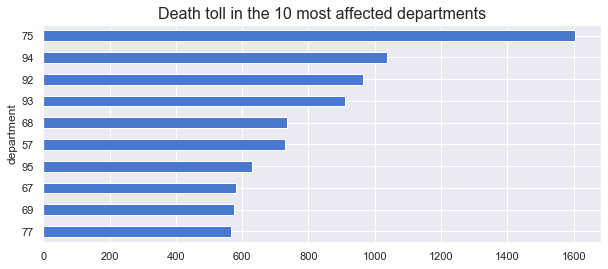

In [52]:
# last record date
max_date = df_hospital.date.max()

# We group by date and department
df_hospital_groupby = df_hospital.groupby(['date','department']).sum()

# Fundamental distributions of data 
df_deaths = df_hospital_groupby.loc[max_date].death

plt.title("Death toll in the 10 most affected departments", fontsize=16)
df_deaths.sort_values(ascending=True)[-10:].plot(kind='barh', rot=0, figsize=(10, 4));

> Ile de France (the department 75 including Paris) is the most affected territory. It was expected since it is the most populated one.

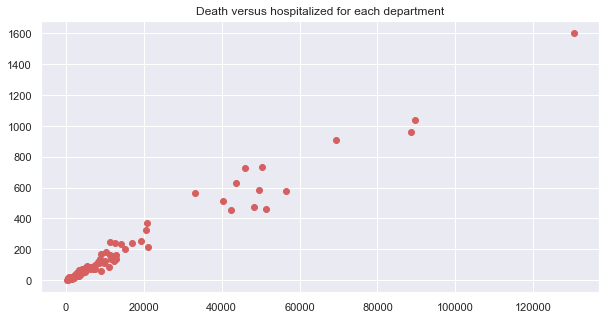

In [53]:
# Plot of death against hospitalized for each departments
plt.figure(figsize=(10, 5))
plt.scatter(df_hospital_groupby_department['hospitalized'],
            df_hospital_groupby.loc[max(df_hospital_groupby.index.get_level_values(0)) ,:]['death'][:-5],
           color='R')
plt.title("Death versus hospitalized for each department")
plt.show()

> The plot above emphasizes great disparities between French regions. They are not all affected in the same way by the Covid outbreak. <br>
Nonetheless a linear correlation can be spotted, which proves the medical response of the regions seemed to be equivalent.

* Let's take a closer look at the energy dataframe:

In [54]:
df_energy_groupby.head()

general_consumption  thermal_power  \
date       region                                                        
2020-01-01 Auvergne-Rhône-Alpes             8402.187500     215.270833   
           Bourgogne-Franche-Comté          2643.291667     173.937500   
           Bretagne                         2844.937500     235.916667   
           Centre-Val de Loire              2502.229167     103.520833   
           Grand-Est                        5360.645833     941.708333   

                                    nuclear_power  
date       region                                  
2020-01-01 Auvergne-Rhône-Alpes      11668.833333  
           Bourgogne-Franche-Comté            NaN  
           Bretagne                           NaN  
           Centre-Val de Loire        8151.729167  
           Grand-Est                 12030.937500

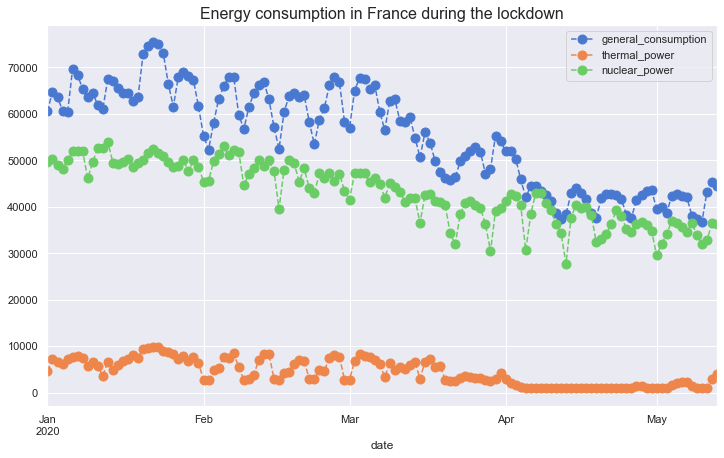

In [55]:
# Energy consumption over time for the whole country during lockdown
df_evolution = df_energy_groupby.sum(level=0)
df_evolution.plot(y=["general_consumption", "thermal_power", "nuclear_power"],
                  marker='o', markersize=9, linestyle='--',
                  figsize=(12,7))
plt.title("Energy consumption in France during the lockdown",fontsize=16);

> We only kept thermal and nuclear energy, which represent the most important source of energy used in France. Energy consumption is cyclical, and often lower at weekends, even during the lockdown. Maybe because some factories are still open during the week, and working from home with connected devices consumes energy.

* Now let's move to flights data

In [56]:
# Which are the most used airports?
df_flights_airports.origin_airport_name.value_counts(sort=True, ascending=False)[:10]

Charles de Gaulle Airport             67461
Orly Airport                          42697
Lyon–Saint-Exupéry Airport             7150
Marseille Provence Airport             5406
Toulouse–Blagnac Airport               4156
Bordeaux–Mérignac Airport (BA 106)     3077
Nantes Atlantique Airport              1530
Berre - La Fare Aerodrome (UAF)         840
Lille Airport                           579
Strasbourg Airport (BA 124)             517
Name: origin_airport_name, dtype: int64

> Most flights are concentrated in the two airports near Paris: Orly and Charles de Gaulle.

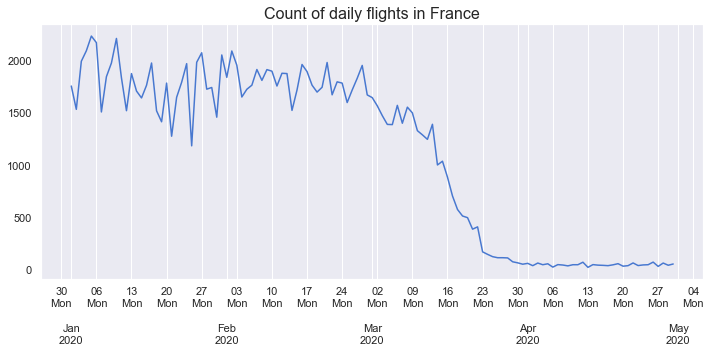

In [57]:
# Plot of the number of flights each day in France
df_flights_airports_groupby = df_flights_airports.groupby('day').count()["origin_airport_name"]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot_date(df_flights_airports_groupby.index,
             df_flights_airports_groupby.values,
             '-')

ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0),
                                                interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

plt.title('Count of daily flights in France', fontsize=16)
plt.tight_layout()
plt.show()

> As expected, the number of flights decreased a lot as soon as the start of the lockdown was announced (March 16).

* Finaly, a quick diving in air quality data

In [58]:
# See all types of indicators measured
df_air.Specie.unique()

array(['wind gust', 'wind-gust', 'humidity', 'wind-speed', 'pm10', 'pm25',
       'no2', 'dew', 'temperature', 'wind speed', 'pressure', 'co', 'o3',
       'so2', 'precipitation'], dtype=object)

> We were interested in pollution indicators. According to specialized websites, we then only kept pm10, pm25, no2, co, so2, o3.

In [59]:
# Look at the variance of co:
df_air[df_air["Specie"] == "co"]["median"].var()

9.452732901463399e-31

> As the co indicators variations are way too small, we choose to remove it.

# <span style="color:#990000"> III - Data Analysis <a class="anchor" id="third-part">

### <span style="color:#990000"> **Below are the functions we have coded to realize our interactive plots. To go to the analysis part and see the result directly, click [here](#data_analysis).**

## <span style="color:#008000"> General variables for Bokeh

In [60]:
""" Definition of general variables used in all bokeh Maps/Plots """

# Chose color palette
import bokeh.palettes as palettes

from bokeh.palettes import Viridis256 as palette
palette = tuple(reversed(palette))

# Other palettes
from bokeh.palettes import Inferno256 as palette_inferno
palette_inferno = tuple(reversed(palette_inferno))

from bokeh.palettes import RdYlGn as palette_11
palette_11 = palette_11[11]


# List of tools used in all Bokeh plots/maps
TOOLS = "pan,wheel_zoom,reset,hover,save"


""" To see the plot in Jupyter Notebook"""
output_notebook()

Loading BokehJS ...

## <span style="color:#008000"> General function for interactive multi-line plot in Bokeh

In [61]:
""" -------------------- Funtion to plot multi lines --------------------  """

def plot_bokeh_multi_lines(dataframes, title, 
                           dates_str,
                           label_modes,
                           line_width=1, size=8, plot_width=300, plot_height=220, 
                           tools="pan,wheel_zoom,reset,save", toolbar_location='below'):
    
    """ ----------- Dictionnary of data to pass to bokeh as argument and variables -----------  """
    df=dataframes[0]
    source = ColumnDataSource(df)
    col_names = source.column_names[1:-1] #not to take the index or integer column
    
    # Secondary source for visible circles
    visible_circles = df[df.integer == 0]
    source_visible=ColumnDataSource(visible_circles)

    """ ----------- Create a palette of colors -----------  """
    colors = palettes.all_palettes['Category10'][max(3,len(col_names))][:len(col_names)]
    
    """ ----------- Create the figure with lines and circles -----------  """
    p = figure(title=title,
               x_axis_type="datetime",
               plot_width=plot_width, plot_height=plot_height,
                   sizing_mode="scale_width",
               toolbar_location=toolbar_location, 
               tools=tools)
    
    # Create dictionary to store lines
    p_dict = dict() 
    
    for col, c, col_name in zip(df.columns[:-1], #not to take integer column
                                colors, col_names):
        # Add lines
        p_dict[col_name] = p.line('date', col, source=source, 
                                  color=c, line_width=line_width,
                                  muted_alpha=0.2)
        # Add circles
        p.circle('date', col, source=source_visible, 
                color=c, size=size,
                muted_alpha=0.2)
        
        # Add hover effect
        p.add_tools(HoverTool(
                            renderers=[p_dict[col_name]],
                            tooltips=[('date','@date{%Y-%m-%d}'),(col, f'@{col}')],
                            formatters={'@date': 'datetime'}))

    # Add legends to items as tuple containing both the name of the column and its line
    legend = Legend(items=[(x, [p_dict[x]]) for x in p_dict]) 
    p.add_layout(legend,'right')
    
    # Assign the click policy 
    p.legend.click_policy="mute" 
        
  
    """ ----------- Set up callbacks -----------  """
    # Update Map while changing feature or mode
    def update_map(attrname, old, new):
        # Switch current dataframe
        df=dataframes[button_mode.active]
        source.data = df
        
        int_date = date_slider.value  #Retrieve current date
        visible_circles = df[(df.integer == int_date)]
        source_visible.data = visible_circles
            
            
    # Update the slider on a click of the user
    def slider_update(attrname, old, new):
        # Retrieve current date
        int_date = date_slider.value
        date_slider.title = "Date :" + dates_str[int_date]
        
        # Change data
        df=dataframes[0]
        if len(label_modes)>0:
            df=dataframes[button_mode.active]
        visible_circles = df[(df['integer'] == int_date)]
        source_visible.data = visible_circles
        
    
    # Update the slider automatically when clicking on the animation button
    def animate_update():
        int_date = date_slider.value + 1
        # Go back to the beginning if slider reach the end
        if int_date > len(dates_str) - 1 :
            int_date = 0
        date_slider.value = int_date


    # Change the button label depending if it is playing or not
    callback_id = None
    def animate():
        global callback_id
        if button_animation.label == '► Play':
            button_animation.label = '❚❚ Pause'
            callback_id = curdoc().add_periodic_callback(animate_update, 200)
        else:
            button_animation.label = '► Play'
            curdoc().remove_periodic_callback(callback_id)
            
            
    """ ----------- Set up widgets and events -----------  """
    # Slider for the date
    date_slider = Slider(title="Date "+ dates_str[0], start = 0, end = len(dates_str)-1, value = 0, step=1, show_value=False)
    date_slider.on_change('value', slider_update)
            
    # Button to animate the slider
    button_animation = Button(label='► Play', width=60)
    button_animation.on_click(animate)

    # Set up inputs for layout
    inputs = widgetbox(date_slider, button_animation)
    
    # Set up Button to choose the displayed mode if they exists
    if len(label_modes)>0:
        button_mode = RadioButtonGroup(labels= label_modes, active=0)
        button_mode.on_change('active', update_map)
        # As the RadioButton isn't implemented with a title option, we add a PreText object before it
        title_button_mode = PreText(text= "Choose feature", style={'font-size':'12pt', 
                         'color': 'black', 
                         'font-family': 'sans-serif'})
        # update inputs
        inputs = widgetbox(title_button_mode, button_mode, date_slider, button_animation)
        
    # Set up layouts and add to document
    layout_doc = layout(p, inputs, sizing_mode="scale_width")
     

    
    """ Run the interaction in the bokeh Map in the Jupyter Notebook """
    # All server related code is added in the modify_doc function
    def modify_doc(doc): # To run the code in a bokeh server, simply replace calls to modify_doc to calls to curdoc() 
        doc.add_root(layout_doc)
        doc.title = title

    handler = FunctionHandler(modify_doc)
    app = Application(handler)
    show(app, notebook_url = notebook_url)
    
    """
    # If you want to display this code on a web browser with a bokeh server, replace the previous seciton with this one
    # and remove the output_notebook() at the beginning of the code
    
    curdoc().add_root(layout)
    curdoc().title = title
    """ 

## <span style="color:#008000"> Function to compute Bokeh Map for each set of data

### <span style="color:#008000">a- Hospital Data

In [62]:
""" -------------------- Funtion to handle the plot of all bokeh maps --------------------  """
def plot_all_bokeh_map_hospital(title, 
                                data_rate, data_min_max, 
                                name_tooltips,
                               TypeColorMapper=LinearColorMapper,
                               plot_width=450, plot_height=400, 
                               tools=TOOLS, palette=palette):
        
    
    """ ----------- Create the color mapper -----------  """
    color_mapper = TypeColorMapper(palette=palette, low=data_min_max['synthesis']['hospitalized']["min"], high=data_min_max['synthesis']['hospitalized']["max"])

    
    """ ----------- Dictionnary of data to pass to bokeh as argument and variables -----------  """
    
    data=dict(x = lon_by_department,
              y = lat_by_department,
              name = name_department,
              rate = data_rate["synthesis"]['hospitalized'])
    
    source=ColumnDataSource(data)
    
    """ ----------- Create the figure -----------  """
    p = figure(title=title, tools=tools,
               x_axis_location=None, y_axis_location=None,
               plot_width=plot_width, plot_height=plot_height,
               tooltips=[("Name", "@name"), (name_tooltips, "@rate"), ("(Long, Lat)", "($x, $y)")]
              )
    p.grid.grid_line_color = None
    p.hover.point_policy = "follow_mouse"

    p.patches('x', 'y', source=source,
              fill_color={'field': 'rate', 'transform': color_mapper},
              fill_alpha=0.7, line_color="black", line_width=0.5)

    #Add color bar to figure
    color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                         label_standoff=12, border_line_color=None, location=(0,0))

    p.add_layout(color_bar, 'right')
    
    
    """ ----------- Set up callbacks -----------  """
    # Update Map while changing feature or mode
    def update_map(attrname, old, new):
        
        # Retrieve the new feature and mode to use
        feature = label_features[button_choice.active] 
        mode = label_modes[button_mode.active] 
        
        # Update the title of the graph
        title_update(feature, mode)
        
        # Update the color map
        color_mapper_update(feature, mode)
        
        # Update map
        if mode == "synthesis":
            source.data['rate'] = data_rate[mode][feature]
            date_slider.visible = False # Hide timeline slider
            button_animation.visible = False # Hide animation button
        else:
            int_date = date_slider.value # Get integer for the currently chosen date in the slider
            source.data['rate'] = data_rate[mode][feature][int_date]
            date_slider.visible = True   # Show timeline
            button_animation.visible = True # Show animation button
    
    
    # Update title of map when feature or mode is changed
    def title_update(feature, mode):
        if mode == "synthesis" or mode == "by_date":
            if feature == "hospitalized":
                first_word = "Hospitalized"
            if feature == "intensive_care":
                first_word = "Intensive-cares"
            if feature == "death":
                first_word = "Deaths"
            if mode == "by_date":
                new_title = first_word + " by day since the beginning of Covid-19 spread"
            else:
                new_title = first_word + " since the beginning of Covid-19 spread"
        else:
            if feature == "hospitalized":
                second_word = "hospitalized"
            if feature == "intensive_care":
                second_word = "intensive-cares"
            if feature == "death":
                second_word = "deaths"
            new_title = "Cumulated " + second_word +  " since the beginning of Covid-19 spread"
        p.title.text = new_title
                
      
        
    # Update color mapper of map when features or mode displayed are changed
    def color_mapper_update(feature, mode):
        # Change the limits of the Color Mapper
        color_mapper.update(low = data_min_max[mode][feature]["min"], high = data_min_max[mode][feature]["max"])
            
    
    # Update the slider on a click of the user
    def slider_update(attrname, old, new):
        # Retrieve current date
        int_date = date_slider.value 
        date_slider.title = "Date :" + hospital_dates_str[int_date]
        
        # Retrieve current feature and mode label
        mode = label_modes[button_mode.active]
        feature = label_features[button_choice.active]
        
        # Change data
        source.data['rate'] = data_rate[mode][feature][int_date]
    
    
    # Update the slider automatically when clicking on the animation button
    def animate_update():
        int_date = date_slider.value + 1
        # Go back to the beginning if slider reach the end
        if int_date > len(hospital_dates_str) - 1 :
            int_date = 0
        date_slider.value = int_date


    # Change the button label depending if it is playing or not
    callback_id = None
    def animate():
        global callback_id
        if button_animation.label == '► Play':
            button_animation.label = '❚❚ Pause'
            callback_id = curdoc().add_periodic_callback(animate_update, 200)
        else:
            button_animation.label = '► Play'
            curdoc().remove_periodic_callback(callback_id)
        
        
    """ ----------- Set up widgets and events -----------  """
    # Button to choose the feature to display in the map
    label_features = ["hospitalized", "intensive_care", "death"] # labels of possible features
    button_choice = RadioButtonGroup(labels=["Hospitalized", "Intensive Care", "Death"], active=0)
    button_choice.on_change('active', update_map)
    # As the RadioButton isn't implemented with a title option, we add a PreText object before it
    title_button_choice = PreText(text= "Choose the feature to display", style={'font-size':'12pt', 
                     'color': 'black', 
                     'font-family': 'sans-serif'})
    
    
    # Button to choose the displayed mode: synthesis, by_date, cumulated
    label_modes = ["synthesis", "by_date", "cumulated"] # labels of possible features
    button_mode = RadioButtonGroup(labels= ["Synthesis", "By Day", "Cumulated"], active=0)
    button_mode.on_change('active', update_map)
    # As the RadioButton isn't implemented with a title option, we add a PreText object before it
    title_button_mode = PreText(text= "Choose display mode ", style={'font-size':'12pt', 
                     'color': 'black', 
                     'font-family': 'sans-serif'})
    
    # Slider for the date
    date_slider = Slider(title="Date "+ hospital_dates_str[0], start = 0, end = len(hospital_dates_str)-1, value = 0, step=1, show_value=False)
    date_slider.on_change('value', slider_update)
    date_slider.visible = False # Initially the slider is not visible

    # Button to animate the slider
    button_animation = Button(label='► Play', width=60)
    button_animation.on_click(animate)
    button_animation.visible = False # Initially the slider is not visible
       

    # Set up layouts and add to document
    inputs = widgetbox(title_button_choice, button_choice, title_button_mode, button_mode, date_slider, button_animation)
    layout = row(p, inputs)
    

    
    """ Run the interaction in the bokeh Map in the Jupyter Notebook """
    
    # All server related code is added in the modify_doc function
    def modify_doc(doc): # To run the code in a bokeh server, simply replace calls to modify_doc to calls to curdoc() 
        doc.add_root(layout)
        doc.title = title


    handler = FunctionHandler(modify_doc)
    app = Application(handler)
    show(app, notebook_url = notebook_url)
    
    
    """
    # If you want to display this code on a web browser with a bokeh server, replace the previous seciton with this one
    # and remove the output_notebook() at the beginning of the code
    
    curdoc().add_root(layout)
    curdoc().title = title
    """ 

### <span style="color:#008000">b- Energy data

In [63]:
""" -------------------- Funtion to handle the plot of all bokeh maps --------------------  """
def plot_all_bokeh_map_energy(title, 
                                data_rate, data_min_max, 
                                name_tooltips,
                               TypeColorMapper=LinearColorMapper,
                               plot_width=450, plot_height=400, 
                               tools=TOOLS, palette=palette_inferno):
        
    
    """ ----------- Create the color mapper -----------  """
    color_mapper = TypeColorMapper(palette=palette, low=data_min_max['by_date']['general_consumption']['min'], high=data_min_max['by_date']['general_consumption']['max'])

    
    """ ----------- Dictionnary of data to pass to bokeh as argument and variables -----------  """
    mode = 'by_date' #mode by default and the only one implemented yet
    
    data=dict(x = lon_by_department,
              y = lat_by_department,
              name = name_department,
              rate = data_rate["by_date"]['general_consumption'][0])
    
    source=ColumnDataSource(data)
    
    """ ----------- Create the figure -----------  """
    p = figure(title=title, tools=tools,
               x_axis_location=None, y_axis_location=None,
               plot_width=plot_width, plot_height=plot_height,
               tooltips=[("Name", "@name"), (name_tooltips, "@rate"), ("(Long, Lat)", "($x, $y)")]
              )
    p.grid.grid_line_color = None
    p.hover.point_policy = "follow_mouse"

    p.patches('x', 'y', source=source,
              fill_color={'field': 'rate', 'transform': color_mapper},
              fill_alpha=0.7, line_color="black", line_width=0.5)

    #Add color bar to figure
    color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                         label_standoff=12, border_line_color=None, location=(0,0))

    p.add_layout(color_bar, 'right')
    
    
    """ ----------- Set up callbacks -----------  """
    # Update Map while changing feature or mode
    def update_map(attrname, old, new):
        
        # Retrieve the new feature to use
        feature = label_features[button_choice.active] 
        
        # Update the title of the graph
        title_update(feature, mode)
        
        # Update the color map
        color_mapper_update(feature, mode)
        
        # Update map
        int_date = date_slider.value # Get integer for the currently chosen date in the slider
        source.data['rate'] = data_rate[mode][feature][int_date]

    
    
    # Update title of map when feature or mode is changed
    def title_update(feature, mode):
        if mode == 'by_date':
            if feature == "general_consumption":
                new_title = "General energy consumption per Day"
            if feature == "thermal_power":
                new_title = "Thermal power production per Day"
            if feature == "nuclear_power":
                new_title = "Nuclear power production per Day"
        p.title.text = new_title
                
      
        
    # Update color mapper of map when features or mode displayed are changed
    def color_mapper_update(feature, mode):
        # Change the limits of the Color Mapper
        color_mapper.update(low = data_min_max[mode][feature]["min"], high = data_min_max[mode][feature]["max"])
            
    
    # Update the slider on a click of the user
    def slider_update(attrname, old, new):
        # Retrieve current date
        int_date = date_slider.value 
        date_slider.title = "Date :" + energy_dates_str[int_date]
        
        # Retrieve current feature Label
        feature = label_features[button_choice.active]
        
        # Change data
        source.data['rate'] = data_rate[mode][feature][int_date]
    
    
    # Update the slider automatically when clicking on the animation button
    def animate_update():
        int_date = date_slider.value + 1
        # Go back to the beginning if slider reach the end
        if int_date > len(energy_dates_str) - 2 :
            int_date = 0
        date_slider.value = int_date


    # Change the button label depending if it is playing or not
    callback_id = None
    def animate():
        global callback_id
        if button_animation.label == '► Play':
            button_animation.label = '❚❚ Pause'
            callback_id = curdoc().add_periodic_callback(animate_update, 200)
        else:
            button_animation.label = '► Play'
            curdoc().remove_periodic_callback(callback_id)
        
        
    """ ----------- Set up widgets and events -----------  """
    # Button to choose the feature to display in the map
    label_features = ["general_consumption", "thermal_power", "nuclear_power"] # labels of possible features
    button_choice = RadioButtonGroup(labels=["General Consumption", "Thermal Power", "Nuclear Power"], active=0)
    button_choice.on_change('active', update_map)
    # As the RadioButton isn't implemented with a title option, we add a PreText object before it
    title_button_choice = PreText(text= "Choose the feature to display", style={'font-size':'12pt', 
                     'color': 'black', 
                     'font-family': 'sans-serif'})
    
    
    # Slider for the date
    date_slider = Slider(title="Date "+ energy_dates_str[0], start = 0, end = len(energy_dates_str)-2, value = 0, step=1, show_value=False)
    date_slider.on_change('value', slider_update)

    # Button to animate the slider
    button_animation = Button(label='► Play', width=60)
    button_animation.on_click(animate)
    button_animation.visible = False # Initially the slider is not visible
    
    # Special mention 
    title_explanation = PreText(text= "Departments in yellow have an unknown consumption", style={'font-size':'9pt', 
                     'color': 'black', 
                     'font-family': 'sans-serif'})
       

    # Set up layouts and add to document
    inputs = widgetbox(title_button_choice, button_choice, date_slider, button_animation, title_explanation)
    layout = row(p, inputs)
    

    
    """ Run the interaction in the bokeh Map in the Jupyter Notebook """
    
    # All server related code is added in the modify_doc function
    def modify_doc(doc): # To run the code in a bokeh server, simply replace calls to modify_doc to calls to curdoc() 
        doc.add_root(layout)
        doc.title = title


    handler = FunctionHandler(modify_doc)
    app = Application(handler)
    show(app, notebook_url = notebook_url)
    
    
    """
    # If you want to display this code on a web browser with a bokeh server, replace the previous seciton with this one
    # and remove the output_notebook() at the beginning of the code
    
    curdoc().add_root(layout)
    curdoc().title = title
    """ 

### <span style="color:#008000">c- Airline traffic

In [64]:
""" -------------------- Funtion to handle the plot the air pollution bokeh Map --------------------  """
def plot_bokeh_map_flights(title, 
                                data_rate, 
                                data_size, 
                               plot_width=450, plot_height=400, 
                               tools=TOOLS):
        

    """ ----------- Dictionnary of data to pass to bokeh as argument and variables -----------  """
    
    # Data for the Shape of France on Map
    data_shape =dict(x = lon_by_department,
              y = lat_by_department,
              name = name_department)
    
    source = ColumnDataSource(data_shape)
    
    
    # Data for the Shape of France on Map
    data_cities1 = dict(x = lon_city_airport,
              y = lat_city_airport,
              sizes = data_size["intranational"][0],
              name = airport_cities,
              rate = data_rate["intranational"][0])
    data_cities = ColumnDataSource(data_cities1)
    
    

    """ ----------- Create the figure -----------  """
    
    # General render of the shape of France and its departments
    p = figure(title=title, 
               # tools=tools, # Hide tooltip for departments
               toolbar_location = 'below',
               x_axis_location=None, y_axis_location=None,
               plot_width=plot_width, plot_height=plot_height,
               # tooltips=[("Department", "@name"), ("(Long, Lat)", "($x, $y)")] 
              )
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    # p.hover.point_policy = "follow_mouse"

    p.patches('x', 'y', source=source,
              fill_color=None, 
              line_color = 'gray', 
              line_width = 0.25, 
              fill_alpha = 1)

    
    # Add circle at the position of cities
    # Their size depends of the air pollution rate
    cities_points = p.circle('x', 'y', size = 'sizes', source = data_cities, 
                     color = 'red',  
                     alpha = 0.3, 
                     name="circle")
    
    
    p.add_tools(HoverTool(renderers = [cities_points],
                      tooltips = [('City', '@name'),
                                  ("(Long, Lat)", "($x, $y)"),
                                  ('Number of flights', '@rate'),]))
    
    """ ----------- Set up callbacks -----------  """          
    
    # Update Map while changing feature or mode
    def update_map(attrname, old, new):
        
        # Retrieve the new feature to use
        feature = label_features[button_choice.active] 
        
                
        # Update map
        int_date = date_slider.value # Get integer for the currently chosen date in the slider
        data_cities.data['rate'] = data_rate[feature][int_date]
        
        # Change color of points in figure
        if button_choice.active == 1:
            cities_points.glyph.fill_color = 'blue'
            cities_points.glyph.line_color = 'blue'
        else:
            cities_points.glyph.fill_color = 'red'
            cities_points.glyph.line_color = 'red'
        
        
    # Update the slider on a click of the user
    def slider_update(attrname, old, new):
        # Retrieve current date
        int_date = date_slider.value 
        date_slider.title = "Date :" + flights_dates_str[int_date]
        
        # Retrieve current feature Label
        feature = label_features[button_choice.active]
        
        # Change data
        data_cities.data['rate'] = data_rate[feature][int_date]
        data_cities.data['sizes'] = data_size[feature][int_date]
        
        # Change size of points in figure
        cities_points.glyph.size = 'sizes'

                
    
    # Update the slider automatically when clicking on the animation button
    def animate_update():
        int_date = date_slider.value + 1
        # Go back to the beginning if slider reach the end
        if int_date > len(flights_dates_str) - 1 :
            int_date = 0
        date_slider.value = int_date


    # Change the button label depending if it is playing or not
    callback_id = None
    def animate():
        global callback_id
        if button_animation.label == '► Play':
            button_animation.label = '❚❚ Pause'
            callback_id = curdoc().add_periodic_callback(animate_update, 200)
        else:
            button_animation.label = '► Play'
            curdoc().remove_periodic_callback(callback_id)

        
    """ ----------- Set up widgets and events -----------  """
    
    # Button to choose the feature to display in the map
    label_features = ["intranational", "international"] # labels of possible features
    button_choice = RadioButtonGroup(labels=["Intranational", "International"], active=0)
    button_choice.on_change('active', update_map)
    # As the RadioButton isn't implemented with a title option, we add a PreText object before it
    title_button_choice = PreText(text= "Choose the type of flights to visualize", style={'font-size':'12pt', 
                     'color': 'black', 
                     'font-family': 'sans-serif'})
    
    # Description for Slider
    slider_explanation = PreText(text= "Slider per day", style={'font-size':'9pt', 
                     'color': 'black', 
                     'font-family': 'sans-serif'})
    
    # Slider for the date
    date_slider = Slider(title="Date "+ flights_dates_str[0], start = 0, end = len(flights_dates_str)-1, value = 0, step=1, show_value=False)
    date_slider.on_change('value', slider_update)

    # Button to animate the slider
    button_animation = Button(label='► Play', width=60)
    button_animation.on_click(animate)
    
    title_lockdown = PreText(text= "Lockdown begins in France on March 16", style={'font-size':'12pt', 
                     'color': 'black', 
                     'font-family': 'sans-serif'})

    # Set up layouts and add to document
    inputs = widgetbox(title_button_choice, button_choice, slider_explanation, date_slider, button_animation, title_lockdown)
    layout = row(p, inputs)
    
    
    
    
    """ Run the interaction in the bokeh Map in the Jupyter Notebook """
    
    # All server related code is added in the modify_doc function
    def modify_doc(doc): # To run the code in a bokeh server, simply replace calls to modify_doc to calls to curdoc() 
        doc.add_root(layout)
        doc.title = title


    handler = FunctionHandler(modify_doc)
    app = Application(handler)
    show(app, notebook_url = notebook_url)
    
    
    """
    # If you want to display this code on a web browser with a bokeh server, replace the previous section with this one
    # and remove the output_notebook() at the beginning of the code
    
    curdoc().add_root(layout)
    curdoc().title = title
    """

### <span style="color:#008000">d- Air quality

In [65]:
""" -------------------- Funtion to handle the plot the air pollution bokeh Map --------------------  """
def plot_bokeh_map_air_polution_comparison(title,
                                title1, title2, 
                                data_rate1,
                                data_rate2,
                                data_min_max,
                                air_dates_str1,
                                air_dates_str2,
                                palette=palette_11, 
                                tools=TOOLS,
                               plot_width=380, plot_height=400):
        
    
    """ ----------- Create the color mapper -----------  """
    color_mapper = linear_cmap(field_name='rate', palette=palette ,low=data_min_max["pm10"]["min"] ,high=data_min_max["pm10"]["max"])


    """ ----------- Dictionnary of data to pass to bokeh as argument and variables -----------  """
    
    # Data for the Shape of France on Map
    data_shape =dict(x = lon_by_department,
              y = lat_by_department,
              name = name_department)
    
    source = ColumnDataSource(data_shape)
    
    
    # Data concerning corona map
    data_cities1 = dict(x = lon_city,
              y = lat_city,
              name = air_cities,
              rate = data_rate1["pm10"][0])
    data_cities_source1 = ColumnDataSource(data_cities1)
    
    
    # Data concerning corona map
    data_cities2 = dict(x = lon_city,
              y = lat_city,
              name = air_cities,
              rate = data_rate2["pm10"][0])
    data_cities_source2 = ColumnDataSource(data_cities2)
    
    

    """ ----------- Create the figures -----------  """
    
    # General render of the shape of France and its departments
    def create_figure_departments(title, data_cities, source = source, color_mapper = color_mapper):
        p = figure(title=title, 
                   # tools=tools, # Hide tooltip for departments
                   toolbar_location = 'below',
                   x_axis_location=None, y_axis_location=None,
                   plot_width=plot_width, plot_height=plot_height,
                   sizing_mode="scale_width",
                   # tooltips=[("Department", "@name"), ("(Long, Lat)", "($x, $y)")] 
                  )

        p.xgrid.grid_line_color = None
        p.ygrid.grid_line_color = None
        # p.hover.point_policy = "follow_mouse"

        p.patches('x', 'y', source=source,
                  fill_color=None, 
                  line_color = 'gray', 
                  line_width = 0.25, 
                  fill_alpha = 1) 
        
        # Add circle at the position of cities
        # Their size depends of the air pollution rate
        cities_points = p.circle('x', 'y', size = 25, source = data_cities, 
                         line_color = color_mapper, color = color_mapper, 
                         alpha = 0.45, 
                         name="circle")
        
        p.add_tools(HoverTool(renderers = [cities_points],
                      tooltips = [('City', '@name'),
                                  ("(Long, Lat)", "($x, $y)"),
                                  ('Pollutant concentration', '@rate')]))
    
        return(p, cities_points)
    
    
    figure1, cities_points1 = create_figure_departments(title1, data_cities_source1)
    figure2, cities_points2 = create_figure_departments(title2, data_cities_source2)
    
    
    #Add color to only one of the figures
    color_bar = ColorBar(color_mapper=color_mapper['transform'],
                         label_standoff=12, border_line_color=None, location=(0,0))

    figure2.add_layout(color_bar, 'right')
      
    
    
    
    """ ----------- Set up callbacks -----------  """          
    
    # Update Map while changing feature or mode
    def update_map(attrname, old, new):
        
        # Retrieve the new feature to use
        feature = label_features[button_choice.active] 
        
        # Update color mapper
        color_mapper_update(feature)
        
        # Update maps
        int_date = date_slider.value # Get integer for the currently chosen date in the slider
        data_cities_source1.data['rate'] = data_rate1[feature][int_date]
        data_cities_source2.data['rate'] = data_rate2[feature][int_date]
        
        
    # Update color mapper of map when features displayed are changed
    def color_mapper_update(feature):
        # Change the limits of the Color Mapper
        color_mapper['transform'].low=data_min_max[feature]["min"]
        color_mapper['transform'].high=data_min_max[feature]["max"]
    
    
    # Update the slider on a click of the user
    def slider_update(attrname, old, new):
        # Retrieve current date
        int_date = date_slider.value 
        date_slider.title = "Date Corona: " + air_dates_str1[int_date] + "    - Date 2019: " + air_dates_str2[int_date]
        
        # Retrieve current feature Label
        feature = label_features[button_choice.active]
        
        # Change data
        data_cities_source1.data['rate'] = data_rate1[feature][int_date]
        data_cities_source2.data['rate'] = data_rate2[feature][int_date]
        
        # Change size of points in figure
        # cities_points.glyph.size = 'sizes'

                
    
    # Update the slider automatically when clicking on the animation button
    def animate_update():
        int_date = date_slider.value + 1
        # Go back to the beginning if slider reach the end
        if int_date > len(air_dates_str1) - 1 :
            int_date = 0
        date_slider.value = int_date


    # Change the button label depending if it is playing or not
    callback_id = None
    def animate():
        global callback_id
        if button_animation.label == '► Play':
            button_animation.label = '❚❚ Pause'
            callback_id = curdoc().add_periodic_callback(animate_update, 200)
        else:
            button_animation.label = '► Play'
            curdoc().remove_periodic_callback(callback_id)

        
    """ ----------- Set up widgets and events -----------  """
    
    # Button to choose the feature to display in the map
    label_features = ["pm10", "pm25", "no2", "o3", "so2"] # labels of possible features
    button_choice = RadioButtonGroup(labels=label_features, active=0)
    button_choice.on_change('active', update_map)
    # As the RadioButton isn't implemented with a title option, we add a PreText object before it
    title_button_choice = PreText(text= "Choose the concentration of the pollutants to visualize", 
                                  style={'font-size':'12pt', 
                     'color': 'black', 
                     'font-family': 'sans-serif'})
    
    # Description for Slider
    slider_explanation = PreText(text= "Slider per Week", style={'font-size':'9pt', 
                     'color': 'black', 
                     'font-family': 'sans-serif'})
    
    # Slider for the date
    date_slider = Slider(title="Date Corona: " + air_dates_str1[0] + "    - Date 2019: " + air_dates_str2[0], 
                         start = 0, end = len(air_dates_str1)-1, value = 0, step=1, show_value=False)
    date_slider.on_change('value', slider_update)

    # Button to animate the slider
    button_animation = Button(label='► Play', width=60)
    button_animation.on_click(animate)
    
    
    title_containment = PreText(text= "Lockdown begins in France on March 16", style={'font-size':'12pt', 
                     'color': 'black', 
                     'font-family': 'sans-serif'})

    # Set up layouts and add to document
    inputs = widgetbox(title_button_choice, button_choice, slider_explanation, date_slider, button_animation, title_containment)
    layout_doc = layout([figure1, figure2], inputs, sizing_mode="stretch_both")  
    
    
    
    """ Run the interaction in the bokeh Map in the Jupyter Notebook """
    
    # All server related code is added in the modify_doc function
    def modify_doc(doc): # To run the code in a bokeh server, simply replace calls to modify_doc to calls to curdoc() 
        doc.add_root(layout_doc)
        doc.title = title


    handler = FunctionHandler(modify_doc)
    app = Application(handler)
    show(app, notebook_url = notebook_url)
    
    
    """
    # If you want to display this code on a web browser with a bokeh server, replace the previous section with this one
    # and remove the output_notebook() at the beginning of the code
    
    curdoc().add_root(layout_doc)
    curdoc().title = title
    """

<a id='data_analysis'></a> 
### **Description of the data analysis and what we've learned about the dataset.**

#### <span style="color:#008000"> III.1 Hospital data

In [66]:
plot_all_bokeh_map_hospital("Hospitalized since the beginning of Covid-19", 
                            hospital_data_by_feature ,
                           hospital_data_min_max,
                           "Cases",
                           TypeColorMapper=LogColorMapper)

> Regarding the **synthesis display mode**:
* Not all departments are affected in the same way. Although the departments around Paris have the smallest area, they are by far the most affected. The southern regions are generally less affected. This can be explained by their lower population density.
* When switching between the features **Hospitalized** and **Intensive Care**, the gradient remains roughly the same, so this features seems proportional in each department. In the least affected departments, the gradient is darker for the number of cases in intensive care: the hospitals of these departments probably had to have more space and be able to accommodate more people in intensive care.
* The observation is not the same between the features **Intensive Care** and **Death**. The map is much darker for the first one which is encouraging. Hover the cursor on the most affected departments (in the North / Center of France) and compare the number of cases in intensive care and the number of cases deceased lets get an idea of the hospital response. For instance in the "Moselle", there have been 6963 cases in intensive care against 718 deceased since the beginning whereas in the "North", there have been 9836 cases in intensive care against 510 eceased. This shows that hospital capacities differ depending of the department. They are less adapted in the most affected departments. It would have been interesting to zoom in even more and see the distribution within the cases in the hospitals of a department. For instance, we know from friends working in different hospitals from the "Nord" department that some hospitals are completely overloaded, while others have unused intensive care rooms. This could have allowed us to highlight logistical problems in the management of the virus.

> Regarding the **By Day** and **Cumulated** display modes:
* Hospitalizations cases mainly start increasing in border regions and in Paris (where there are the main airports). So it seems to come first through exchanges with foreign countries.
* It is interesting that it takes about ten days for the hospital and intensive care gradients to stick together. This shows that hospitals have been slow to prepare.
* Even during the lockdown (starting March 16), the virus continued to spread. The lockdown is not sufficient to totaly limite its spread.
* The number of cases decreased slightly and death toll increased in the days before the lockdown was lifted (May 11). The lifting of the lockdown may therefore be premature regarding only hospital data.

Another interesting comparison can be made with the deconfinement map provided by the government on May 11th. 
On this map are represented in red the departments the most at risk, which have known a deconfinement with more strict rules:

![Image](https://www.francetvinfo.fr/image/75rzgbycs-735f/1200/450/21476471.png)

> This choice does not seem to be only correlated with the number of cases: certain regions of the South have a greater gradient of hospitalized than some of the regions chosen (for instance: "Bouches-du-Rhônes"). The deconfinement rule is to prohibit travels of more than 100 km around either to avoid a new spread of the virus. The government may have thought that this rule would not be well respected, and therefore chose to delimit an area in the broad sense, instead of continuing to think in terms of department. The chosen area hosts some of the departments with the largest numbers of cases, as it can bee seen on our Maps.

Let's now have a look at general curves in France:

In [67]:
plot_bokeh_multi_lines([df_hospital_France],"Evolution of the situation in France", 
                       dates_str=hospital_dates_str, 
                       label_modes=[])

* For the line plot, we decided to show the cumulative deaths, because otherwise the data would be too low to view it at the same time as the hospitalization and intensive care data.
* This curve makes it possible to visualize the decrease in the number of people hospitalized and in intensive care since the beginning of the lockdown. The peak has been reached around mid April, and the number of death seems to be stabilized starting in the beginning of May.

#### <span style="color:#008000"> III.2 Energy data

Above all, keep in mind that when we talk about energy, we are talking about electrical energy here.

In [68]:
plot_bokeh_multi_lines([df_consumption, df_thermic, df_nuclear],
                       "French energy consumption and production", 
                       dates_str=energy_dates_str, 
                       label_modes=['Global consumption','Thermic production','Nuclear production']
                      )

> * The global consumption is lower than last year, which should be taken into account in the analysis.
* Overall consumption and all types of production fell sharply during the April lockdown. The decline occurred gradually in March, and the lockdown does not seem to have been respected immediately. We see that overall consumption starts to rise again in May because the lockdown is lifted.
* Nuclear energy provides more than 70% of electricity in France. Its production has decreased little compared to that of thermal energy. The latter is used as a back-up source and was not required during the lockdown ([french source](https://www.edf.fr/groupe-edf/espaces-dedies/l-energie-de-a-a-z/tout-sur-l-energie/produire-de-l-electricite/le-thermique-a-flamme-en-chiffres)).

In [69]:
plot_all_bokeh_map_energy("General Energy Consumption per Day", 
                        energy_data_by_feature,
                           energy_data_min_max_without_0,
                           "Energy consumption in the region",
                           TypeColorMapper=LogColorMapper,
                         palette = palette_inferno)

* From the beginning of April, several regions stopped producing thermal energy, because the other productions (nuclear, green energies) were sufficient. 
* Regarding electricity consumption, it drops drastically at the start of the lockdown. This shows that companies were not prepared for telework, and that it took time to set up. There was thus a much less active period of two weeks starting at the announce of the lockdown.
* There is a very strange jump on the first of April, where consumption is drastically increased compared to the end of March. Regarding nuclear power, production is increasing. Even if nuclear production was slowed down at the beginning due to organisational difficulties and a drop in energy consumption, this increase of production seems too huge. Perhaps the choice was to focus on nuclear power and reduce other energy production (thermal power decreases drastically at the same time) because it requires fewer human resources and therefore limits the spread of the virus among staff. It is also possible that the electrical readings were limited to the end of March due to staff limitations.

#### <span style="color:#008000"> III.3 Airline traffic data

In [70]:
""" -------------------- Plot with a linear mapping --------------------  """

plot_bokeh_map_flights('Flights per airport per day in France', 
                           flight_by_feature, 
                            size_airport_city, 
                            plot_width=450, plot_height=500, 
                            tools=TOOLS)

In [71]:
plot_bokeh_multi_lines([df_air_traffic],"French airline traffic", 
                       dates_str=air_dates_str, 
                       label_modes=[]
                      )

> * The number of trips is already decreasing before the announcement of the lockdown (March 16).
* Most airports closed when the lockdown was announced. Only Paris still operates a decent amount of flights during the lockdown.
* There are many international flights (around 500 per day) at the two Paris airports at the start of the lockdown. This is in line with the encouragement of the various embassies for people to return to their home country.
* Surprisingly, there are still some intranational flights during the lockdown.

#### <span style="color:#008000"> III.4 Air quality data

In [72]:
plot_bokeh_multi_lines([df_no2,df_so2,df_o3,df_pm10,df_pm25],
                       "Emission of pollutants in France", 
                       dates_str=quality_dates_str, 
                       label_modes=['no2','so2','o3','pm10','pm25']
                      )

We displayed a lot of different indicators. Here is a short description we found on Wikipedia for each of them:
* **pm10** and **pm25** are particulate matters, mainly produced through industrial processes (bulk material handling, combustion and minerals processing), natural sources (bushfires, dust storms, pollens and sea spray), vehicles 
* **so2** is a gas, coming 99% from human sources: industrial activity (generation of electricity, process of some minerals, fossil fuels burning) and motor vehicle emissions
* **o3** is formed due to industrial activity and various constituents released into the air, mainly from road traffic. Its rate also changes naturally according to the seasons and increases in spring / summer
* **no2** forms from emissions from cars, trucks and buses, power plants, and off-road equipment

> It is quite difficult to draw conclusions from the single curves for non specialists, since most indicators also depend on the seasons. However, we have seen a very marked decrease in the level of so2 (the only indicator that is almost completely linked to human activity) since the start of the spread of the virus, which has halved nationwide.

Further analysis can be carried out by comparing maps from this year and last year:

In [73]:
plot_bokeh_map_air_polution_comparison('Comparison air pollution before and during Covid-19',
                        'Air Pollution in France - Beginning of 2020', 
                            'Air Pollution in France at the same period in 2019',
                           air_pollution_by_pollutant_corona,
                            air_pollution_by_pollutant_2019,
                            air_data_min_max,
                            air_dates_str_corona,
                            air_dates_str_2019)

> * We note that the emissions before lockdown are generally higher this year than last year.
* The largest emissions of pollutants are not all located in Paris as one would expect from the density of pollution and the number of vehicles in circulation, but rather in the cities of North and North West. These are indeed cities close to industrial zones.
* In some cities, the pollutants measurements were not made during all days of the lockdown (example: Lille). This result in a value of 0 for the concentration onc some pollutants.
* Generally, we see a decrease in pollution gradients for all species compared to last year during the lockdown period. This indicates a decrease in road traffic as well as a slowdown in the industry.

### **Description of the machine learning: Comparison with Italy and Spain through a polynomial regression**

How is the situation in France compared to its neighbours?

In [74]:
number_min_days = np.min([len(dict_death['Italy']),len(dict_death['Spain'])])
number_min_days

# Fill X and y features 
X=[]
y=[]
for i in range(number_min_days):
    X.append(i)
    X.append(i)
    y.append(dict_death['Italy'][i])
    y.append(dict_death['Spain'][i])
X = np.array(X).reshape(-1,1)
y = np.array(y).reshape(-1,1)

In [75]:
# sklearn Polynomial regression
poly = PolynomialFeatures(degree=5, include_bias=False)
X_polynomial = poly.fit_transform(X) # We don't actually fit anything here but fitting is required when a data transformer used for the first time

model = LinearRegression()

model.fit(X, y) 
y_pred = model.predict(X)
print("Regression with 1 degree, RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

model.fit(X_polynomial, y) 
y_pred_polynomial = model.predict(X_polynomial)
print("Regression with 5 degrees, RMSE:", np.sqrt(mean_squared_error(y, y_pred_polynomial)))

Regression with 1 degree, RMSE: 1605.405559041005
Regression with 5 degrees, RMSE: 820.2051102566404


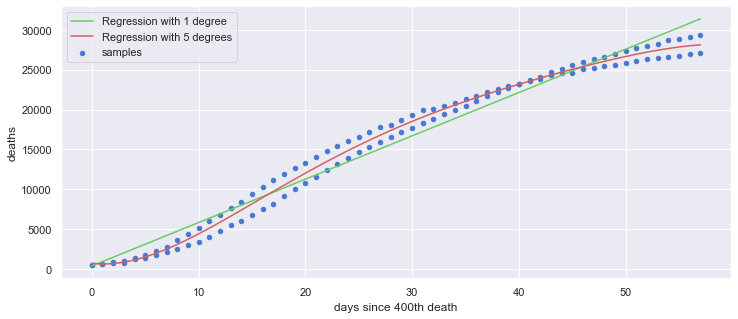

In [76]:
#plot
plt.figure(figsize=(12, 5))
plt.scatter(X, y, s=20, label='samples')
plt.plot(X, y_pred, c='g', label="Regression with 1 degree")
plt.plot(X, y_pred_polynomial, c='r', label="Regression with 5 degrees")
plt.xlabel("days since 400th death")
plt.ylabel("deaths")
plt.legend(loc="best")
plt.show()

> It's better to do the regression with 5 degrees. <br>
Now, let's apply this regression with 5 degrees to the 9 most affected countries excluding France.

**ARIMA forecasting:**

Let's do dome forecasting for the death toll.<br>

The Autoregressive Integrated Moving Average (ARIMA) method models the next step in the sequence as a linear function of the differenced observations and residual errors at prior time steps. <br>

It combines both Autoregression (AR) and Moving Average (MA) models as well as a differencing pre-processing step of the sequence to make the sequence stationary, called integration (I).

To determine parameters value of the ARIMA model, we plot ACF and PACF.

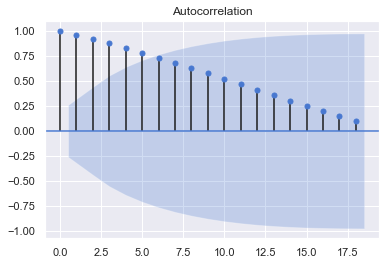

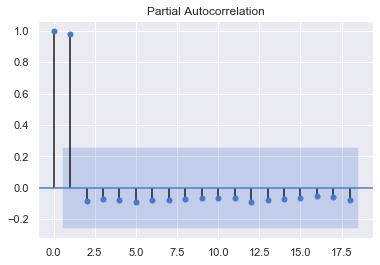

In [78]:
plot_acf(df_hospital_France['Cumulated_deceased'])
plot_pacf(df_hospital_France['Cumulated_deceased']);

In the autocorrelation plot, the first two sticks above the confidence interval. So 2 will be the moving average value. <br>
Regarding auto regression, the partial autocorrelation plot indicates a value of 1 is the maximum.

In [ ]:
# Fit ARIMA model
model = ARIMA(df_hospital_France['Cumulated deceased'], order=(1,1,2))
arima = model.fit()

y_pred_arima=arima.predict(max(df_hospital_France.index)+datetime.timedelta(days=1), 
                     max(df_hospital_France.index)+datetime.timedelta(days=10), #10 days forecasting
                     typ='levels'
                    )

In [ ]:
# Plot
plt.figure(figsize=(12, 5))
plt.scatter(df_hospital_France['integer'],df_hospital_France['Cumulated deceased'], label='France cumulated deceased')
plt.scatter(range(max(df_hospital_France['integer'])+1,
                  max(df_hospital_France['integer'])+1+len(y_pred_arima)),y_pred_arima,
           label='France deaths forecasted')
plt.plot(X, y_pred_polynomial, c='r', label="Spain and Italy polynomial regression")
plt.legend(loc='best')
plt.xlabel("Days since 400th death")
plt.ylabel("Cumulated deceased")
plt.show()

> France has suffered from fewer deaths than Italy and Spain. Perharps the lockdown decided earlier, stricter health measures and a bigger health system capacity has helped the country to stem the tide of the outbreak. 

# <span style="color:#990000"> IV - Genre <a class="anchor" id="fourth-part">

### **Which genre of data story did you use?**
> We chose an interactive slideshow, with a reader-driven approach. The maps we have done are rich in information, and each user will probably draw different conclusions in the light of his/her interests and knowledges of the situation.

### **Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?**
> From the Visual Narrative categories, we used:
* A consistent visual platform, to give a constant frame for the reader to navigate into
* Feature distinction, for the highlighting process


### **Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?**
> From the Narrative Structure categories, we used:
* A user directed path, as we wanted to give the user freedom upon the order in which to view the topics
* Hover highlighting, navigation buttons and filtering for the interactivity, as well as explicit instructions.
* Captions and annotations, for the context

# <span style="color:#990000"> V - Vizualizations <a class="anchor" id="fifth-part">

###  **Explain the visualizations you've chosen.**
> We chose to display **interactive maps and line plots**. 

> The maps appeared as the most suited visualizations we could use to display the geographical evolution of our data: cities in the air quality dataset, airports in the flights dataset, and region or department data for the two others. With maps, we could for instance highlight how differently the east of France and the Paris region are affected differently from the rest of the country. For some of them, the user can also select a specific date on a slider, to be able to compare at their own pace the evolution of the dataset on both a geographical basis and a temporal basis.

> The line plots are used in our website to show the temporal evolution of the data: they highlight especially how much of a difference the beginning of the lockdown made in some of our datasets, and also give us the opportunity to visually compare the 2020 data with the 2019 data, to give the reader an idea of how the situation could be without the pandemic occurring. 
  
> Both our maps and line plots are interactive, meaning that they provide additional information to the reader upon hovering. Some also provide a "Play" function, to allow for an automatic geographical and temporal visualization.


###  **Why are they right for the story you want to tell?**
> Interactive maps and line plots, as explained in the previous section, give to the reader a precise idea of both the geographical and temporal evolution of the data, which is specifically important to tell our story: we want the user to be able to discover the different impact of the pandemic depending on the region of France, but also the evolution before/after the lockdown.

# <span style="color:#990000"> VI - Discussion <a class="anchor" id="sixth-part">

###  What went well? What is still missing? What could be improved?

> There are some things that could have been added to the graphs to make them even more meaningful that we thought about but that we didn't have time to put in place:
* Regarding **hospital data**, it could have been interesting to put the data in relation to other data such as the population density or the number of inhabitants for each region. 
* For the **energy data**: another feature to implement could be green energies. It would also have been interesting to add the consumption shares (industry, household, ...). We would expect to see more energy consumption in households and less in factories. 
* For the **flights data**: with more time, we would have liked to compare with last year's flights as for air quality, and to allow the user to observe departure and arrival flights differently. There are probably more return flights abroad to France than flights in the other direction. It would also have been interesting to visualize the data of French expatriates in the main countries and compare it with the number of flights which still ensure the transition.
* Concerning **air quality data**, it would have probably been more useful to show the curves to compare last year and this year instead of the min/median/max.






> Concerning the tools we chose to use:
* Navigation could have been improved. For example, it could have been interesting to offer the user to display the maps he wants at the same time. It would have been much easier to implement it in javascript if we had worked with a library like d3. Implementing this option under Bokeh is possible but would have involved even more code redundancy.
* As we wanted to use interactive Bokeh charts, we needed to use a Bokeh server. The best way to display Bokeh server plots on a website we found is to use the Django framework, with embedded plots. But hosting a Django website with such plots did not work with a AWS host, nor with a Heroku host. We ended up having to host the website locally, which provided us with additional flexibility. An improvement would be to be able to host this website on an online host.

# <span style="color:#990000"> VII - Contributions <a class="anchor" id="seventh-part">

<table style="width:100%; text-align:left;">
  <tr>
    <th style="text-align:left">Gaétan Moisson-Franckhauser</th>
    <th style="text-align:left">Brian Tang</th>
    <th style="text-align:left">Tanguy Navez</th>
  </tr>
  <tr>
    <td style="text-align:left">Website, Explainer notebook</td>
    <td style="text-align:left">Bokeh line plots, Explainer notebook</td>
    <td style="text-align:left">Bokeh Maps, Explainer Notebook</td>
  </tr>
</table> 